# Elo Challenge - Final Notebook for Group Presentation

## Table of Content
- [1.Introduction](#1.-Introduction)
    - [1.1 Understanding the Challenge of the Competition ](#1.1-Understanding-the-Challenge-of-the-Competition)
    - [1.2 Understanding the Meaning of the Data](#1.2-Understanding-the-Meaning-of-the-Data)
- [2. Data Loading](#2.-Data-Loading)
- [3. Exploratory Data Analysis of Datasets](#3.-Exploratory-Data-Analysis-of-Datasets)
    - [3.1 Exploration of Train and Test Data](#3.1-Exploration-of-Train-and-Test-Data)
    - [3.2 Exploration of other Data Sources](#3.2-Exploration-of-other-Data-Sources)
        - [3.2.1 Merchant.csv](#3.2.1-Merchant.csv)
        - [3.2.2 History_transactions.csv](#3.2.2-History_transactions.csv)
        - [3.2.3 Feature Analysis](#3.2.3-Feature-Analysis)
- [4. Data Preprocessing](#4.-Data-Preprocessing)
- [5. Data Cleaning](#5.-Data-Cleaning)
- [6. Models](#6.-Models)
    - [6.1 Linear Regression](#6.1-Linear-Regression)
    - [6.2 Ridge Regression](#6.2-Ridge-Regression)
    - [6.3 Lasso Regression](#6.3-Lasso-Regression)
    - [6.4 Decision Tree Regressor](#6.4-Decision-Tree-Regressor)
    - [6.5 Random Forest](#6.5-Random-Forest)
- [7. Feature Importance](#7.-Feature-Importance)
- [8. Model Submission](#8.-Model-Submission)
- [9. Conclusion](#8.-Conclusion)

## 1. Introduction

This notebook provides an overview of possible problem-solving approaches to solve the ELO Challenge. The underlying chapters can be accessed via a click on the the Table of Content above.  The report commences with an introduction of the challenge of the competition and an overview of the provided data sets for a better understanding. Due to the immense size of certain data sets, they will be comprised before an Exploratory Data Analysis (EDA) is performed. After analyzing the different data sets, data preprocessing and data cleaning will be performed before data models will be applied. This report illustrates different models that are used to fit the data: Linear Regression, Ridge Regression, Lasso, Decision Tree Regressor and Random Forest. 



### 1.1 Understanding the Challenge of the Competition

The Objective of the challenge is to "identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty" (see https://www.kaggle.com/c/elo-merchant-category-recommendation#description). Hence, the aim is to predict the loyalty score for each card_id which is represented in the test.csv and sample_submission.csv. This shall help Elo to create the desired experience for its customers and avoid ineffective customer campaigns by targeting in the right way.

### 1.2 Understanding the Meaning of the Data

First we wanted to understand better which datasets are provided in order to solve the challenge of Elo. We therefore looked at all data sets and the description provided on Kaggle. 

Description of the csv-files (Kaggle website):
* train.csv - the training set
* test.csv - the test set
* sample_submission.csv - a sample submission file in the correct format with all card_ids we want to predict for
* historical_transactions.csv - up to 3 months worth of historical transactions for each card_id
* merchants.csv - additional information about all merchants / merchant_ids in the dataset
* new_merchant_transactions.csv - two months worth of data for each card_id containing all purchases that card_id made at merchant_ids that were not visited in the historical data
* Data_Dictionary.xlsl - description of each column in the provided datasets

Before we started loading and exploring the data sets, we wanted to understand the provided sample submission in order to know right from the beginning what the scope of the Elo Challenge is and where our analysis and data modeling should lead us to.

In [2]:
import pandas as pd
sample_submission = pd.read_csv("../loecher/public/sample_submission.csv.gz")
print(sample_submission.head())
print('Shape of sample_submission: ', sample_submission.shape)

           card_id  target
0  C_ID_0ab67a22ab       0
1  C_ID_130fd0cbdd       0
2  C_ID_b709037bc5       0
3  C_ID_d27d835a9f       0
4  C_ID_2b5e3df5c2       0
Shape of sample_submission:  (123623, 2)


We can see that our result should be a csv file that contains all card_ids we want to predict the loyalty score ("target") for. In total we need to provide 123.623 data entries. Our submissions will then be scored on the root mean squared error (RMSE) to evaluate our performance in the leaderboard.

## 2. Data Loading

First we imported relevant libraries for our analysis (additional packages will be imported later on).

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
sns.set(style="darkgrid")

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

Considering the memory limitations, we need to reduce the size of historical_transactions. It is the biggest dataset in this Kernel. Inspired by Fabien Kernel, we decrease the size of our data to prevent a probable memory overflow.

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

After reducing the datasets, we could read the data into a Pandas DataFrame. The result below shows the percentage in reduction of the relevant datasets as well as the heads of the different datasets for a better understanding.

In [5]:
df_train = reduce_mem_usage(pd.read_csv("../loecher/public/train.csv.gz",parse_dates=["first_active_month"]))
df_test = reduce_mem_usage(pd.read_csv("../loecher/public/test.csv.gz",parse_dates=["first_active_month"]))
df_hist_trans = reduce_mem_usage(pd.read_csv("../loecher/public/historical_transactions.csv.gz",parse_dates=["purchase_date"]))
df_new_merchant_trans = reduce_mem_usage(pd.read_csv("../loecher/public/new_merchant_transactions.csv.gz",parse_dates=["purchase_date"]))
df_merchants = reduce_mem_usage(pd.read_csv("../loecher/public/merchants.csv.gz"))

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)
Mem. usage decreased to 1749.11 Mb (43.7% reduction)
Mem. usage decreased to 114.20 Mb (45.5% reduction)
Mem. usage decreased to 30.32 Mb (46.0% reduction)


In [6]:
print("Training Data Sample");display(df_train.head())
print("Test Data Sample");display(df_test.head())
print("Merchant Data Sample");display(df_merchants.head())
print("Historical Transactions Sample");display(df_hist_trans.head())
print("New Merchant Transactions Sample");display(df_new_merchant_trans.head())

Training Data Sample


first_active_month          card_id  feature_1  feature_2  feature_3  \
0         2017-06-01  C_ID_92a2005557          5          2          1   
1         2017-01-01  C_ID_3d0044924f          4          1          0   
2         2016-08-01  C_ID_d639edf6cd          2          2          0   
3         2017-09-01  C_ID_186d6a6901          4          3          0   
4         2017-11-01  C_ID_cdbd2c0db2          1          3          0   

     target  
0 -0.820312  
1  0.392822  
2  0.687988  
3  0.142456  
4 -0.159790

Test Data Sample


first_active_month          card_id  feature_1  feature_2  feature_3
0         2017-04-01  C_ID_0ab67a22ab          3          3          1
1         2017-01-01  C_ID_130fd0cbdd          2          3          0
2         2017-08-01  C_ID_b709037bc5          5          1          1
3         2017-12-01  C_ID_d27d835a9f          2          1          0
4         2015-12-01  C_ID_2b5e3df5c2          5          1          1

Merchant Data Sample


merchant_id  merchant_group_id  merchant_category_id  subsector_id  \
0  M_ID_838061e48c               8353                   792             9   
1  M_ID_9339d880ad               3184                   840            20   
2  M_ID_e726bbae1e                447                   690             1   
3  M_ID_a70e9c5f81               5026                   792             9   
4  M_ID_64456c37ce               2228                   222            21   

   numerical_1  numerical_2 category_1 most_recent_sales_range  \
0    -0.057465    -0.057465          N                       E   
1    -0.057465    -0.057465          N                       E   
2    -0.057465    -0.057465          N                       E   
3    -0.057465    -0.057465          Y                       E   
4    -0.057465    -0.057465          Y                       E   

  most_recent_purchases_range  avg_sales_lag3     ...      avg_sales_lag6  \
0                           E       -0.400000     ...           -2.250000   
1                           E       -0.720000     ...           -0.740000   
2                           E      -82.129997     ...          -82.129997   
3                           E             NaN     ...                 NaN   
4                           E             NaN     ...                 NaN   

   avg_purchases_lag6  active_months_lag6  avg_sales_lag12  \
0           18.666667                   6        -2.320000   
1            1.291667                   6        -0.570000   
2          260.000000                   2       -82.129997   
3            4.666667                   6              NaN   
4            0.361111                   6              NaN   

   avg_purchases_lag12  active_months_lag12  category_4  city_id state_id  \
0            13.916667                   12           N      242        9   
1             1.687500                   12           N       22       16   
2           260.000000                    2           N       -1        5   
3             3.833333                   12           Y       -1       -1   
4             0.347222                   12           Y       -1       -1   

   category_2  
0         1.0  
1         1.0  
2         5.0  
3         NaN  
4         NaN  

[5 rows x 22 columns]

Historical Transactions Sample


authorized_flag          card_id  city_id category_1  installments  \
0               Y  C_ID_4e6213e9bc       88          N             0   
1               Y  C_ID_4e6213e9bc       88          N             0   
2               Y  C_ID_4e6213e9bc       88          N             0   
3               Y  C_ID_4e6213e9bc       88          N             0   
4               Y  C_ID_4e6213e9bc       88          N             0   

  category_3  merchant_category_id      merchant_id  month_lag  \
0          A                    80  M_ID_e020e9b302         -8   
1          A                   367  M_ID_86ec983688         -7   
2          A                    80  M_ID_979ed661fc         -6   
3          A                   560  M_ID_e6d5ae8ea6         -5   
4          A                    80  M_ID_e020e9b302        -11   

   purchase_amount       purchase_date  category_2  state_id  subsector_id  
0        -0.703331 2017-06-25 15:33:07         1.0        16            37  
1        -0.733128 2017-07-15 12:10:45         1.0        16            16  
2        -0.720386 2017-08-09 22:04:29         1.0        16            37  
3        -0.735352 2017-09-02 10:06:26         1.0        16            34  
4        -0.722865 2017-03-10 01:14:19         1.0        16            37

New Merchant Transactions Sample


authorized_flag          card_id  city_id category_1  installments  \
0               Y  C_ID_415bb3a509      107          N             1   
1               Y  C_ID_415bb3a509      140          N             1   
2               Y  C_ID_415bb3a509      330          N             1   
3               Y  C_ID_415bb3a509       -1          Y             1   
4               Y  C_ID_ef55cf8d4b       -1          Y             1   

  category_3  merchant_category_id      merchant_id  month_lag  \
0          B                   307  M_ID_b0c793002c          1   
1          B                   307  M_ID_88920c89e8          1   
2          B                   507  M_ID_ad5237ef6b          2   
3          B                   661  M_ID_9e84cda3b1          1   
4          B                   166  M_ID_3c86fa3831          1   

   purchase_amount       purchase_date  category_2  state_id  subsector_id  
0        -0.557617 2018-03-11 14:57:36         1.0         9            19  
1        -0.569336 2018-03-19 18:53:37         1.0         9            19  
2        -0.551270 2018-04-26 14:08:44         1.0         9            14  
3        -0.671875 2018-03-07 09:43:21         NaN        -1             8  
4        -0.659668 2018-03-22 21:07:53         NaN        -1            29

We can see that the traning and test dataset both have three features with numerical values besides the card_id, first_active_month and the target variable. The other datasets (merchant, historical_transactions and new_merchants) contain more columns with both, categorical and continuous variables. An in-depth analysis will be provided in the next chapter.

Before we started the Exploratory Data Analyis (EDA), we defined a function to check missing values and yield the percentage of missing values and columns as seen below.


In [7]:
def missing_values(df):
    total_miss = df.isnull().sum()
    perc_miss = 100 * total_miss / len(df)
    table_miss = pd.concat([total_miss, perc_miss], axis = 1)
    ren_table = table_miss.rename(columns = {0:'Total Miss Values', 1: '% of miss values'})
    ren_table = ren_table[ren_table.iloc[:,1]!=0].sort_values('% of miss values', ascending = False).round(2)
    
    print('You data contains {}'.format(df.shape[1]) + ' columns and has {}'.format(ren_table.shape[0]) + ' colums with missing values' )
    
    return ren_table

In [8]:
print('Train Data');display(missing_values(df_train))
print('Test Data');display(missing_values(df_test))
print('New Merchants');display(missing_values(df_new_merchant_trans))
print('Historical Transactions');display(missing_values(df_hist_trans))
print('Merchants');display(missing_values(df_merchants))

Train Data
You data contains 6 columns and has 0 colums with missing values


Empty DataFrame
Columns: [Total Miss Values, % of miss values]
Index: []

Test Data
You data contains 5 columns and has 1 colums with missing values


Total Miss Values  % of miss values
first_active_month                  1               0.0

New Merchants
You data contains 14 columns and has 3 colums with missing values


Total Miss Values  % of miss values
category_2              111745              5.69
category_3               55922              2.85
merchant_id              26216              1.34

Historical Transactions
You data contains 14 columns and has 3 colums with missing values


Total Miss Values  % of miss values
category_2             2652864              9.11
category_3              178159              0.61
merchant_id             138481              0.48

Merchants
You data contains 22 columns and has 4 colums with missing values


Total Miss Values  % of miss values
category_2                   11887              3.55
avg_sales_lag3                  13              0.00
avg_sales_lag6                  13              0.00
avg_sales_lag12                 13              0.00

The result shows that the train dataset has no missing values and the test dataset has one missing value in the column first_active_month. New_merchants and historical_transactions both consist of 14 columns and have missing values in the columns category_2, category_3 and merchant_id. The merchant dataset has in total 22 columns out of which 4 contain missing values: category_2, avg_sales_lag3, avg_sales_lag6 and avg_sales_lag12.

## 3. Exploratory Data Analysis of Datasets

After loading the datasets and checking for missing values with started with our in-depth Exploratory Data Analysis (EDA). The first part of this chapter takes a closer look on the train and test datasets, while the second part will analyze the other datasets in detail.

### 3.1 Exploration of Train and Test Data

We  checked if the distribution of the train and test datasets is similar which can be seen below. To analyze this we looked at the three features individually and compared them for each dataset.

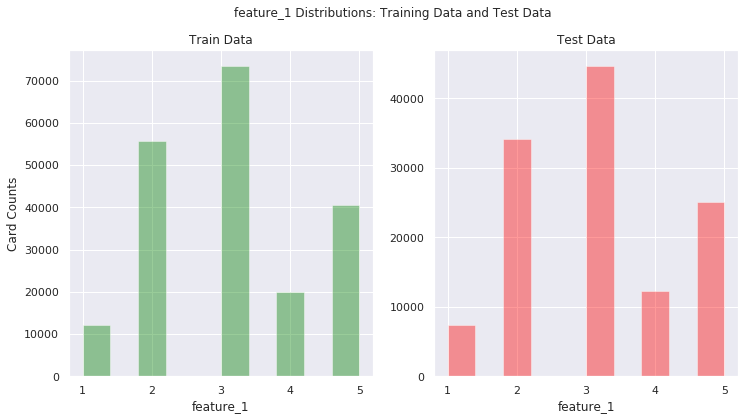

In [9]:
# Feature 1
f, axes = plt.subplots(1, 2, figsize=(12,6))
sns.distplot( df_train.feature_1,ax=axes[0], kde = False, color = 'green', bins=10).set_title("Train Data")

sns.distplot( df_test.feature_1,ax=axes[1], kde = False, color = 'red', bins=10).set_title("Test Data") 
axes[0].set(ylabel='Card Counts')
f.suptitle('feature_1 Distributions: Training Data and Test Data')
axes[0].set_xticks(np.arange(1,6,1))
axes[1].set_xticks(np.arange(1,6,1))
plt.show()

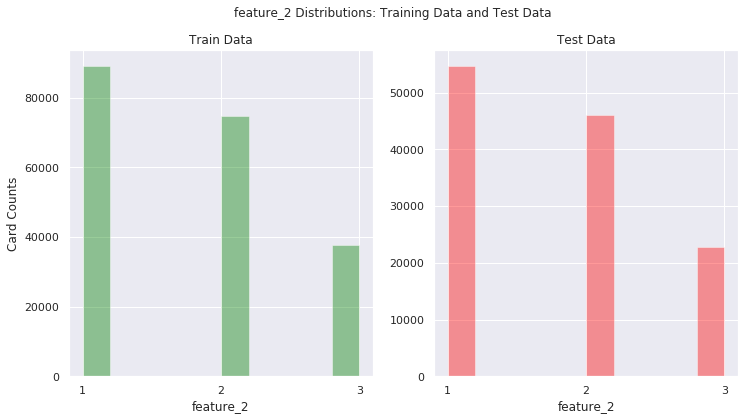

In [10]:
# Feature 2
f, axes = plt.subplots(1, 2, figsize=(12,6))
sns.distplot( df_train.feature_2,ax=axes[0], kde = False, color = 'green', bins=10).set_title("Train Data")

sns.distplot( df_test.feature_2,ax=axes[1], kde = False, color = 'red', bins=10).set_title("Test Data") 
axes[0].set(ylabel='Card Counts')
f.suptitle('feature_2 Distributions: Training Data and Test Data')
axes[0].set_xticks(np.arange(1,4,1))
axes[1].set_xticks(np.arange(1,4,1))
plt.show()

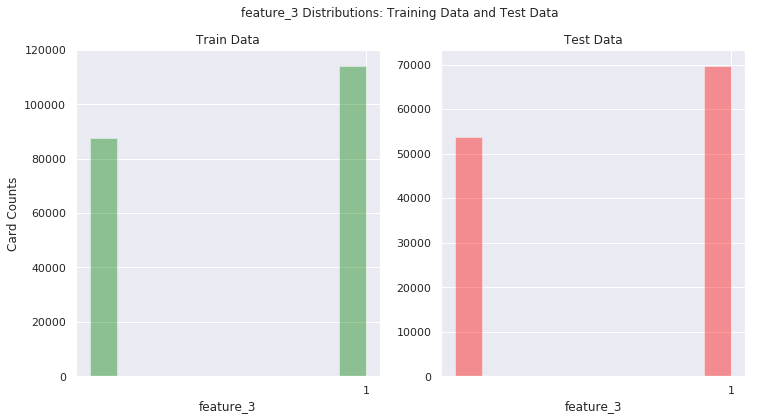

In [11]:
# Feature 3
f, axes = plt.subplots(1, 2, figsize=(12,6))
sns.distplot( df_train.feature_3,ax=axes[0], kde = False, color = 'green', bins=10).set_title("Train Data")

sns.distplot( df_test.feature_3,ax=axes[1], kde = False, color = 'red', bins=10).set_title("Test Data") 
axes[0].set(ylabel='Card Counts')
f.suptitle('feature_3 Distributions: Training Data and Test Data')
axes[0].set_xticks(np.arange(1,2,1))
axes[1].set_xticks(np.arange(1,2,1))
plt.show()

The graphs per feature above show the values they can take and their distribution. We can see that we have the same distribution among train and test data, just with a different amount of card counts. Next, we plotted the first_active_month feature and replaced one missing value. 

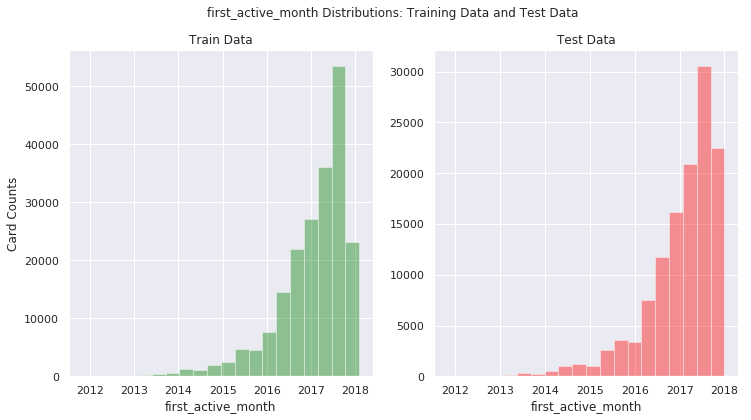

In [12]:
# First_active_month
# Method='ffill' option. 'ffill' stands for 'forward fill' and will propagate the last valid observation forward. 
f, axes = plt.subplots(1, 2, figsize=(12,6))
df_test['first_active_month'] = df_test['first_active_month'] .fillna(axis=0, method='ffill')
sns.distplot( df_train.first_active_month,ax=axes[0], kde = False, color = 'green', bins=20).set_title("Train Data")
sns.distplot( df_test.first_active_month,ax=axes[1], kde = False, color = 'red', bins=20).set_title("Test Data") 
axes[0].set(ylabel='Card Counts')
f.suptitle('first_active_month Distributions: Training Data and Test Data')

plt.show()

Then we looked at the card_id and used describe() for both, train and test card_ids. The result below shows that there are no duplicate values. 

In [13]:
print(df_train.card_id.describe())
print('=='*18)
print(df_test.card_id.describe())

count              201917
unique             201917
top       C_ID_925d946642
freq                    1
Name: card_id, dtype: object
count              123623
unique             123623
top       C_ID_0316fd7257
freq                    1
Name: card_id, dtype: object


Since we only have the target variable in the train data, we then had a look at the distribution of the target variable of the train data. The graph below visualizes this distribution - first as a distribution plot, then as a boxplot. 

Text(0.5,1,'target distribution')

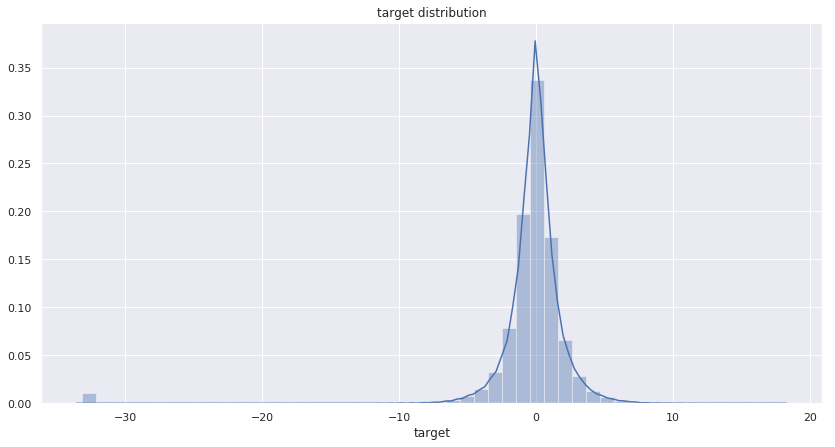

In [14]:
f, ax = plt.subplots(figsize=(14, 7))
sns.distplot(df_train.target)
plt.title('target distribution')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f6854b38cc0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f687b5a8630>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f6854b38b38>],
 'medians': [<matplotlib.lines.Line2D at 0x7f687b5a8ef0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f687b5b07b8>],
 'means': [<matplotlib.lines.Line2D at 0x7f687b5b0390>]}

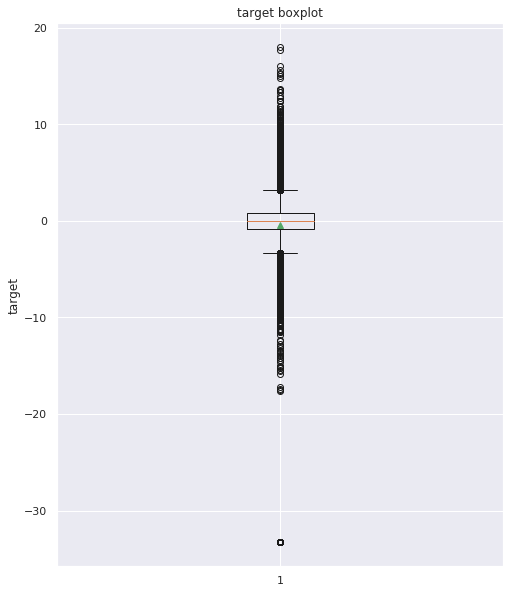

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8,10))
axes.set_title("target boxplot")
axes.set_ylabel("target")
axes.boxplot(list(df_train["target"].values),showmeans=True)

The visualizations before have shown that feature_1, feature_2, feature_3 and first_active month have similar distributions in the train and test data.
Now, let us use a the seaborn pairplot to quickly check if any of the input variables in the training data are clearly correlated with the target variable.

<Figure size 864x576 with 0 Axes>

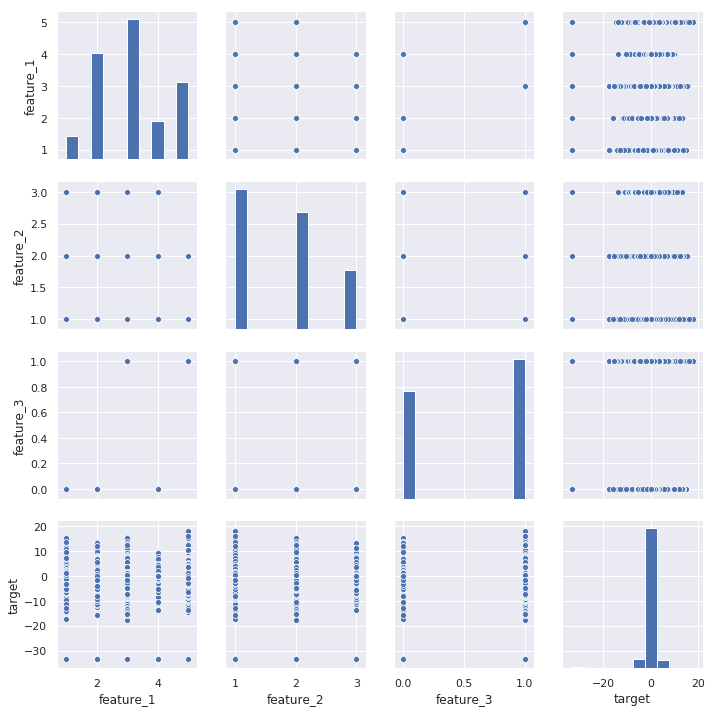

In [16]:
plt.figure(figsize=(12,8))
sns.pairplot(df_train.loc[:,df_train.columns != 'card_id'])

In the pairplots above we can see that there is no collinearity between the features.

A plot of the dependent variable against the independent one is illustrated below (full sample).

Text(0.5,1,'target distribution [feature_3]')

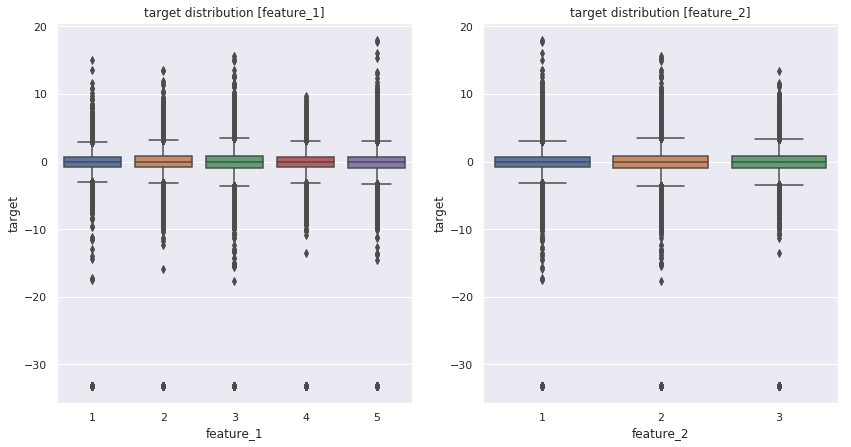

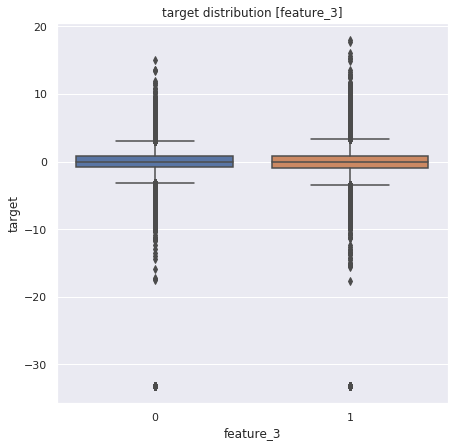

In [17]:
#plotting feature_1 - feature_2 vs target
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(14,7))

fig = sns.boxplot(x='feature_1', y='target', data=df_train,ax=ax1)
ax1.set_title('target distribution [feature_1]')

sns.boxplot(x='feature_2', y='target', data=df_train,ax=ax2)
ax2.set_title('target distribution [feature_2]')

#plotting feature_1 - feature_2 vs target
fig = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
fig = sns.boxplot(x='feature_3', y='target', data=df_train)
plt.title('target distribution [feature_3]')


The three plots visualize that for all three feature values the median of the target variable lays around 0.

## 3.2 Exploration of other Data Sources

#### 3.2.1 Merchant.csv

To analyze the other datasets besides the train and test data, we first took a closer look at the merchant file. In the following cells we analyzed different columns together as the next steps will show in detail.

In [18]:
df_merchants.head()

merchant_id  merchant_group_id  merchant_category_id  subsector_id  \
0  M_ID_838061e48c               8353                   792             9   
1  M_ID_9339d880ad               3184                   840            20   
2  M_ID_e726bbae1e                447                   690             1   
3  M_ID_a70e9c5f81               5026                   792             9   
4  M_ID_64456c37ce               2228                   222            21   

   numerical_1  numerical_2 category_1 most_recent_sales_range  \
0    -0.057465    -0.057465          N                       E   
1    -0.057465    -0.057465          N                       E   
2    -0.057465    -0.057465          N                       E   
3    -0.057465    -0.057465          Y                       E   
4    -0.057465    -0.057465          Y                       E   

  most_recent_purchases_range  avg_sales_lag3     ...      avg_sales_lag6  \
0                           E       -0.400000     ...           -2.250000   
1                           E       -0.720000     ...           -0.740000   
2                           E      -82.129997     ...          -82.129997   
3                           E             NaN     ...                 NaN   
4                           E             NaN     ...                 NaN   

   avg_purchases_lag6  active_months_lag6  avg_sales_lag12  \
0           18.666667                   6        -2.320000   
1            1.291667                   6        -0.570000   
2          260.000000                   2       -82.129997   
3            4.666667                   6              NaN   
4            0.361111                   6              NaN   

   avg_purchases_lag12  active_months_lag12  category_4  city_id state_id  \
0            13.916667                   12           N      242        9   
1             1.687500                   12           N       22       16   
2           260.000000                    2           N       -1        5   
3             3.833333                   12           Y       -1       -1   
4             0.347222                   12           Y       -1       -1   

   category_2  
0         1.0  
1         1.0  
2         5.0  
3         NaN  
4         NaN  

[5 rows x 22 columns]

##### 1.MERCHANT_GROUP_ID & MERCHANT_CATEGORY_ID & SUBSCTOR_ID
First we visualized the following columns together:
* merchant_group_id: Merchant group (anonymized )
* merchant_category_id: Unique identifier for merchant category (anonymized )
* subsector_id: Merchant category group (anonymized )


In [19]:
df_merchants[["merchant_group_id","merchant_category_id","subsector_id"]].head()

merchant_group_id  merchant_category_id  subsector_id
0               8353                   792             9
1               3184                   840            20
2                447                   690             1
3               5026                   792             9
4               2228                   222            21

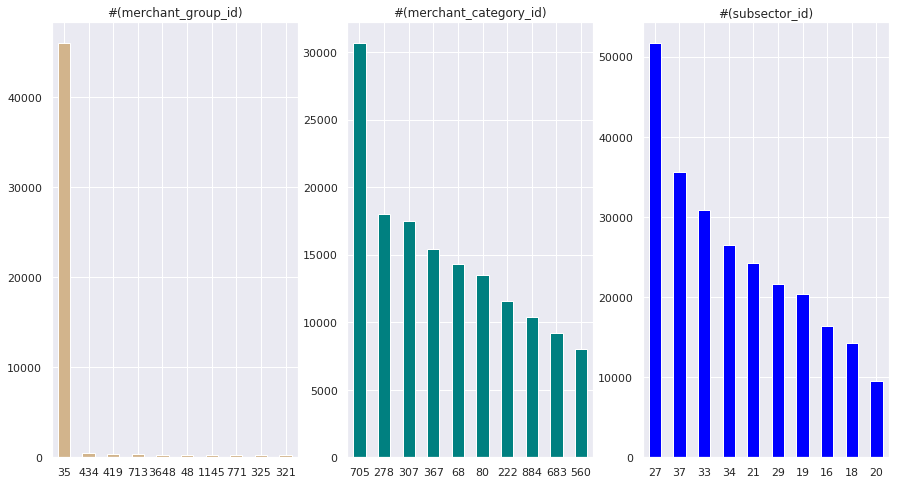

In [20]:
fig,axes = plt.subplots(1,3,figsize=(15,8))
df_merchants["merchant_group_id"].value_counts()[:10].plot(kind="bar",ax = axes[0],
                                                           title="#(merchant_group_id)",
                                                           rot=0,color="tan")
df_merchants["merchant_category_id"].value_counts()[:10].plot(kind="bar",ax=axes[1],
                                                              title="#(merchant_category_id)",
                                                              rot=0,color="teal")
df_merchants["subsector_id"].value_counts()[:10].plot(kind="bar",ax=axes[2],
                                                      title="#(subsector_id)",
                                                      rot=0,color="blue")

Because the merchant_group_id has a skewed distribution, we will change the plot using the np.log() function to generalize the values and get the right distribution.

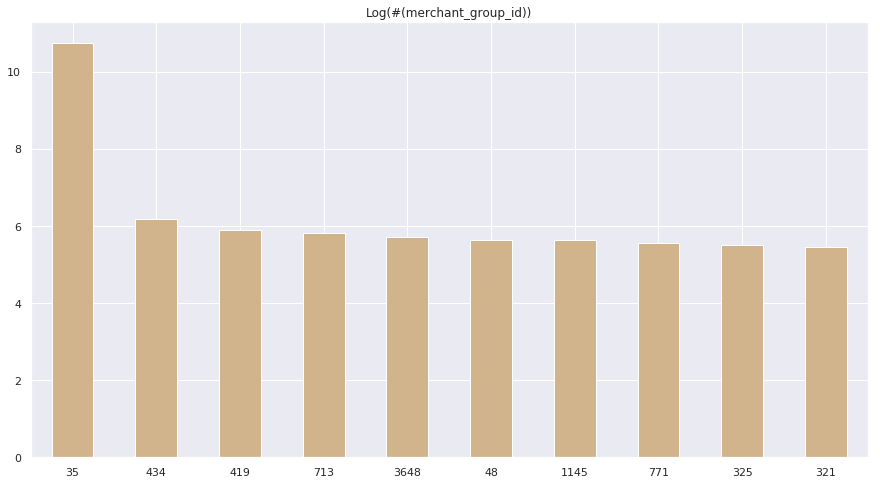

In [21]:
fig = plt.subplots(1,figsize=(15,8))
np.log(df_merchants["merchant_group_id"].value_counts()[:10]).plot(kind="bar",
                                                           title="Log(#(merchant_group_id))",
                                                           rot=0,color="tan")

##### 2. NUMERICAL_1 & NUMERICAL_2
Then we visualized the numerical columns of:
* numerical_1: anonymized measure
* numerical_2: anonymized measure

In [22]:
df_merchants[["numerical_1","numerical_2"]].head()

numerical_1  numerical_2
0    -0.057465    -0.057465
1    -0.057465    -0.057465
2    -0.057465    -0.057465
3    -0.057465    -0.057465
4    -0.057465    -0.057465

In [23]:
pd.concat([df_merchants["numerical_1"],df_merchants["numerical_2"]],axis=1).describe()

numerical_1    numerical_2
count  334696.000000  334696.000000
mean        0.000000       0.000000
std         0.000000       0.000000
min        -0.057465      -0.057465
25%        -0.057465      -0.057465
50%        -0.057465      -0.057465
75%        -0.047546      -0.047546
max       183.750000     182.125000

##### 3. CATEGORY_1 & CATEGORY_2 & CATEGORY_4
Next, we looked at the different categories:
* category_1: anonymized category
* category_2: anonymized category
* category_4: anonymized category

In [24]:
df_merchants[["category_1","category_2","category_4"]].head()

category_1  category_2 category_4
0          N         1.0          N
1          N         1.0          N
2          N         5.0          N
3          Y         NaN          Y
4          Y         NaN          Y

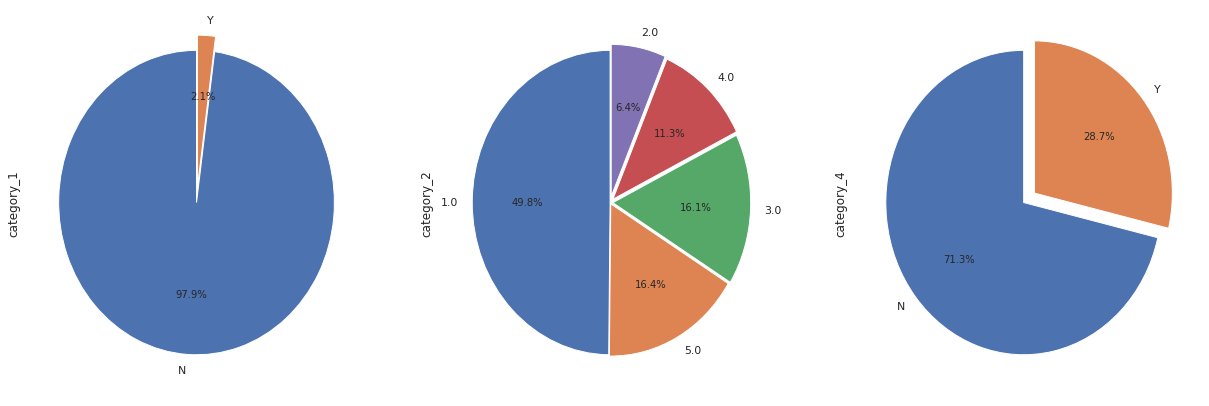

In [25]:
fig,axes = plt.subplots(1,3,figsize=(21,7))
df_merchants["category_1"].value_counts().plot(kind="pie",explode=(0,0.1),
                                               autopct='%1.1f%%',shadow=False, 
                                               startangle=90,ax=axes[0])
df_merchants["category_2"].value_counts().plot(kind="pie",explode=(0,0.01,0.02, 0.03, 0.04),
                                               autopct='%1.1f%%',shadow=False, 
                                               startangle=90,ax=axes[1])
df_merchants["category_4"].value_counts().plot(kind="pie",explode=(0,0.1),
                                               autopct='%1.1f%%',shadow=False, 
                                               startangle=90,ax=axes[2])


##### 4. MOST_RECENT_SALES_RANGE & MOST_RECENT_PURCHASE_RANGE
The next cells provide a visualization of sales and purchase ranges:
* most_recent_sales_range: Range of revenue (monetary units) in last active month --> A > B > C > D > E
* most_recent_purchases_range: Range of quantity of transactions in last active month --> A > B > C > D > E

In [26]:
df_merchants[["most_recent_purchases_range", "most_recent_sales_range"]].head()

most_recent_purchases_range most_recent_sales_range
0                           E                       E
1                           E                       E
2                           E                       E
3                           E                       E
4                           E                       E

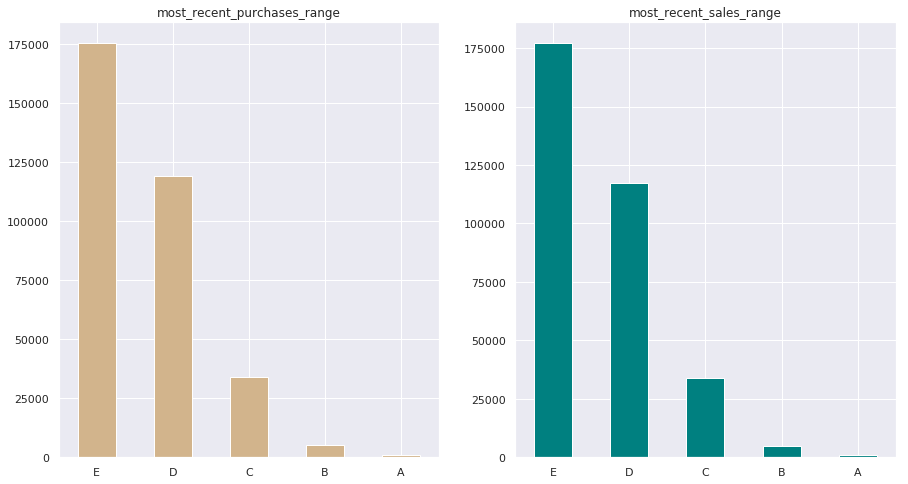

In [27]:
fig,axes = plt.subplots(1,2,figsize=(15,8))
df_merchants["most_recent_purchases_range"].value_counts().plot(kind="bar",ax = axes[0],
                                                                   title="most_recent_purchases_range",
                                                                   rot=0,color="tan")
df_merchants["most_recent_sales_range"].value_counts().plot(kind="bar",ax=axes[1],
                                                              title="most_recent_sales_range",
                                                              rot=0,color="teal")

##### 5. CITY_ID & STATE_ID
After the sales and purchase ranges, we analyzed city and state identifier columns:
* city_id: City identifier (anonymized )
* state_id: State identifier (anonymized)


In [28]:
df_merchants[["city_id","state_id"]].head()

city_id  state_id
0      242         9
1       22        16
2       -1         5
3       -1        -1
4       -1        -1

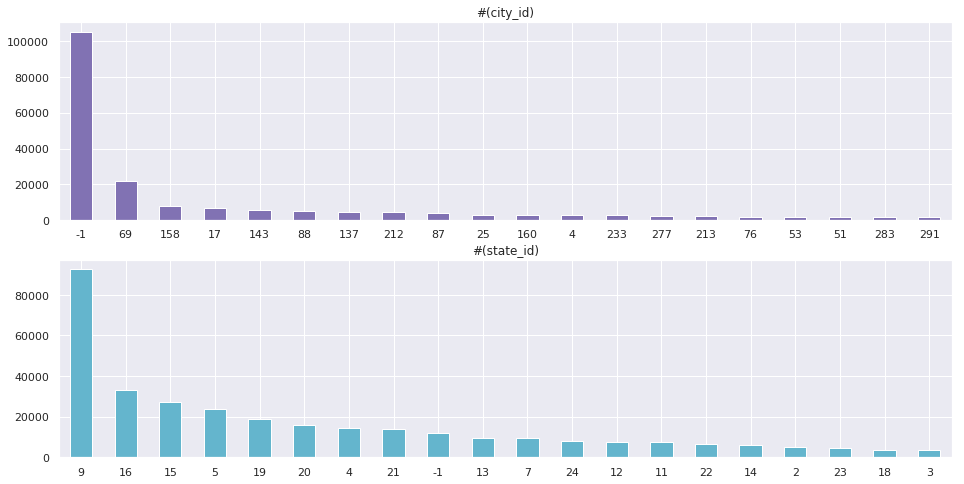

In [29]:
#city_id & #state_id
fig,axes = plt.subplots(2,1,figsize=(16,8))
df_merchants["city_id"].value_counts()[:20].plot(kind="bar",
                                                         title="#(city_id)",
                                                         rot=0,ax=axes[0],color="m")
df_merchants["state_id"].value_counts()[:20].plot(kind="bar",
                                                     title="#(state_id)",
                                                     rot=0,ax=axes[1],color="c")

Because city_id and state_id also have a skewed distribution, we will here also change the plot using the np.log() function to generale the values and get the right distribution.


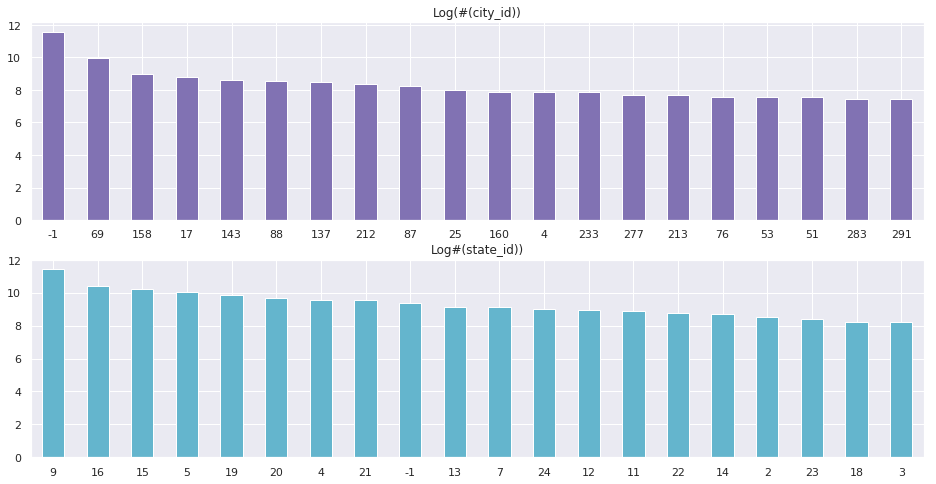

In [30]:
#city_id & #state_id
fig,axes = plt.subplots(2,1,figsize=(16,8))
np.log(df_merchants["city_id"].value_counts()[:20]).plot(kind="bar",
                                                         title="Log(#(city_id))",
                                                         rot=0,ax=axes[0],color="m")
np.log(df_merchants["state_id"].value_counts()[:20]).plot(kind="bar",
                                                     title="Log#(state_id))",
                                                     rot=0,ax=axes[1],color="c")

##### 6. AVG_SALES_LAG3 & AVG_SALES_LAG6 & AVG_SALES_LAG12
In the next two cells we investigated the average revenue columns of:
* avg_sales_lag3: Monthly average of revenue in last 3 months divided by revenue in last active month
* avg_sales_lag6: Monthly average of revenue in last 6 months divided by revenue in last active month
* avg_sales_lag12: Monthly average of revenue in last 12 months divided by revenue in last active month

In [31]:
df_merchants[["avg_sales_lag3","avg_sales_lag6","avg_sales_lag12"]].head()

avg_sales_lag3  avg_sales_lag6  avg_sales_lag12
0       -0.400000       -2.250000        -2.320000
1       -0.720000       -0.740000        -0.570000
2      -82.129997      -82.129997       -82.129997
3             NaN             NaN              NaN
4             NaN             NaN              NaN

In [32]:
df_merchants[["avg_sales_lag3","avg_sales_lag6","avg_sales_lag12"]].describe()

avg_sales_lag3  avg_sales_lag6  avg_sales_lag12
count   334683.000000    3.346830e+05     3.346830e+05
mean        13.832988    2.165079e+01     2.522771e+01
std       2395.489990    3.947108e+03     5.251842e+03
min        -82.129997   -8.213000e+01    -8.213000e+01
25%          0.880000    8.500000e-01     8.500000e-01
50%          1.000000    1.010000e+00     1.020000e+00
75%          1.160000    1.230000e+00     1.290000e+00
max     851844.625000    1.513959e+06     2.567408e+06

##### 7. AVG_PURCHASES_LAG3 & AVG_PURCHASES_LAG6 & AVG_PURCHASES_LAG12
There are three different columns for the monthly average of transactions as illustrated in the next two cells:
* avg_purchases_lag3: Monthly average of transactions in last 3 months divided by transactions in last active month
* avg_purchases_lag6: Monthly average of transactions in last 6 months divided by transactions in last active month
* avg_purchases_lag12: Monthly average of transactions in last 12 months divided by transactions in last active month

In [33]:
df_merchants[["avg_purchases_lag3","avg_purchases_lag6","avg_purchases_lag12"]].head()

avg_purchases_lag3  avg_purchases_lag6  avg_purchases_lag12
0            9.666667           18.666667            13.916667
1            1.750000            1.291667             1.687500
2          260.000000          260.000000           260.000000
3            1.666667            4.666667             3.833333
4            0.500000            0.361111             0.347222

In [34]:
df_merchants[["avg_purchases_lag3","avg_purchases_lag6","avg_purchases_lag12"]].describe()

avg_purchases_lag3  avg_purchases_lag6  avg_purchases_lag12
count        3.346960e+05        3.346960e+05         3.346960e+05
mean                  inf                 inf                  inf
std                   NaN                 NaN                  NaN
min          3.334953e-01        1.670447e-01         9.832954e-02
25%          9.236499e-01        9.022475e-01         8.983333e-01
50%          1.016667e+00        1.026961e+00         1.043361e+00
75%          1.146522e+00        1.215575e+00         1.266480e+00
max                   inf                 inf                  inf

#### 3.2.2 History_transactions.csv

After analyzing the merchant file we explored the history_transactions file also by analyzing different columns.

In [35]:
df_hist_trans.head()

authorized_flag          card_id  city_id category_1  installments  \
0               Y  C_ID_4e6213e9bc       88          N             0   
1               Y  C_ID_4e6213e9bc       88          N             0   
2               Y  C_ID_4e6213e9bc       88          N             0   
3               Y  C_ID_4e6213e9bc       88          N             0   
4               Y  C_ID_4e6213e9bc       88          N             0   

  category_3  merchant_category_id      merchant_id  month_lag  \
0          A                    80  M_ID_e020e9b302         -8   
1          A                   367  M_ID_86ec983688         -7   
2          A                    80  M_ID_979ed661fc         -6   
3          A                   560  M_ID_e6d5ae8ea6         -5   
4          A                    80  M_ID_e020e9b302        -11   

   purchase_amount       purchase_date  category_2  state_id  subsector_id  
0        -0.703331 2017-06-25 15:33:07         1.0        16            37  
1        -0.733128 2017-07-15 12:10:45         1.0        16            16  
2        -0.720386 2017-08-09 22:04:29         1.0        16            37  
3        -0.735352 2017-09-02 10:06:26         1.0        16            34  
4        -0.722865 2017-03-10 01:14:19         1.0        16            37

In [36]:
df_hist_trans.isna().sum()

authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               178159
merchant_category_id          0
merchant_id              138481
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2652864
state_id                      0
subsector_id                  0
dtype: int64

##### 1. AUTHORIZED_FLAG - Y' if approved, 'N' if denied
We first analyzed category 1-3 by considerung Y for approved and N for denied:
* CATEGORY_1 - anonymized category
* CATEGORY_2 - anonymized category
* CATEGORY_3 - anonymized category

In [37]:
df_hist_trans[["authorized_flag", "category_1", "category_3", "category_2"]].head()

authorized_flag category_1 category_3  category_2
0               Y          N          A         1.0
1               Y          N          A         1.0
2               Y          N          A         1.0
3               Y          N          A         1.0
4               Y          N          A         1.0

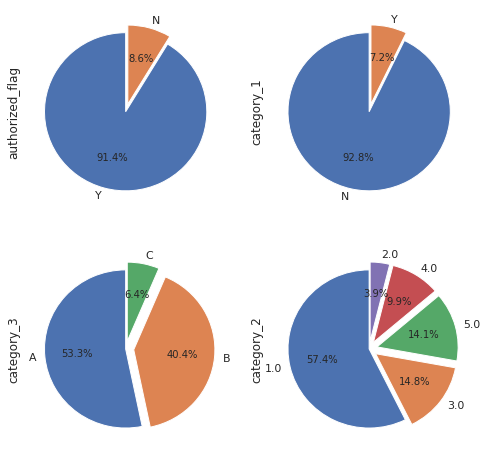

In [38]:
fig,axes = plt.subplots(2,2,figsize=(8,8))
df_hist_trans["authorized_flag"].value_counts().plot(kind="pie",explode=(0,0.1),
                                                     autopct='%1.1f%%',shadow=False, 
                                                     startangle=90,ax=axes[0][0])
df_hist_trans["category_1"].value_counts().plot(kind="pie",explode=(0,0.1),
                                                autopct='%1.1f%%',shadow=False, 
                                                startangle=90,ax=axes[0][1])
df_hist_trans["category_3"].value_counts().plot(kind="pie",explode=(0,0.1,0.1),
                                                autopct='%1.1f%%',shadow=False, 
                                                startangle=90,ax=axes[1][0])
df_hist_trans["category_2"].value_counts().plot(kind="pie",explode=(0,0.1,0.1,0.1,0.1),
                                                autopct='%1.1f%%',shadow=False, 
                                                startangle=90,ax=axes[1][1])

##### 2. PURCHASE_AMOUNT
Next, we discovered the purchase amount of the file.

In [39]:
df_hist_trans.purchase_amount.describe()

count    2.911236e+07
mean     3.640094e-02
std      1.123522e+03
min     -7.469078e-01
25%     -7.203559e-01
50%     -6.883495e-01
75%     -6.032543e-01
max      6.010604e+06
Name: purchase_amount, dtype: float64

In [40]:
df_hist_trans.purchase_amount.head()

0   -0.703331
1   -0.733128
2   -0.720386
3   -0.735352
4   -0.722865
Name: purchase_amount, dtype: float32

There is a huge difference between the 75% percentile and the maximum. We can conclude that there is a peak which may not be related to normal activities. We want to get a 99% percentile in order to validate this.

In [41]:
np.percentile(df_hist_trans["purchase_amount"].values,q=99)

1.2208409547805337

The result shows that 99% of the purchase amounts are less than 1.22. Let's assume the remaining 1% are outliers and move to visualize it.

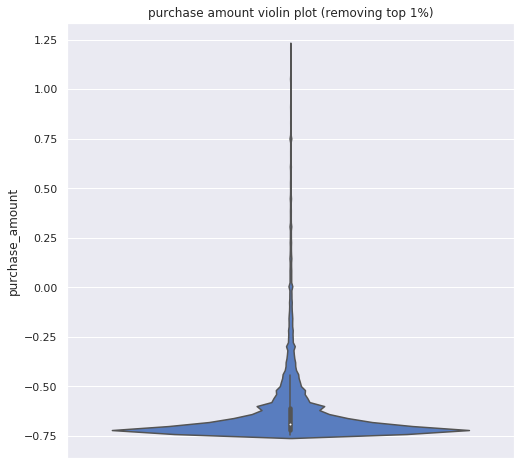

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
axes.set_title("purchase amount violin plot (removing top 1%)")
axes.set_ylabel("purchase_amount")
ax = sns.violinplot(y=list(df_hist_trans[df_hist_trans["purchase_amount"] < np.percentile(df_hist_trans["purchase_amount"],99)]["purchase_amount"]),showmeans=True,showmedians=True, palette="muted")

##### 3. INSTALLMENTS
Then we explored the installments column.

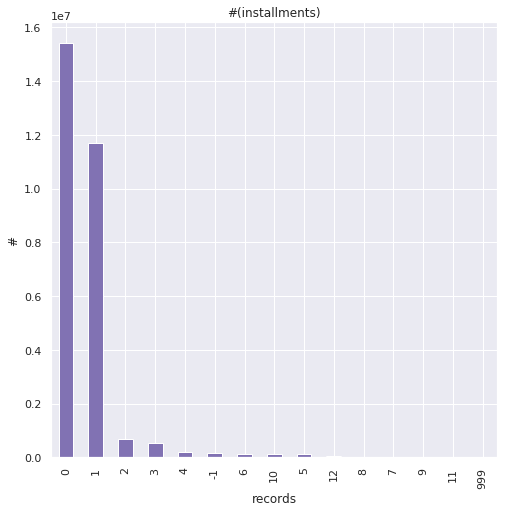

In [43]:
fig,axes = plt.subplots(1,1,figsize=(8,8))
axes.set_title("#(installments)")
axes.set_ylabel("#")
axes.set_xlabel("records")
df_hist_trans.installments.value_counts().plot(kind="bar",color="m")

Because of the skeweness, we use the np.log() function.

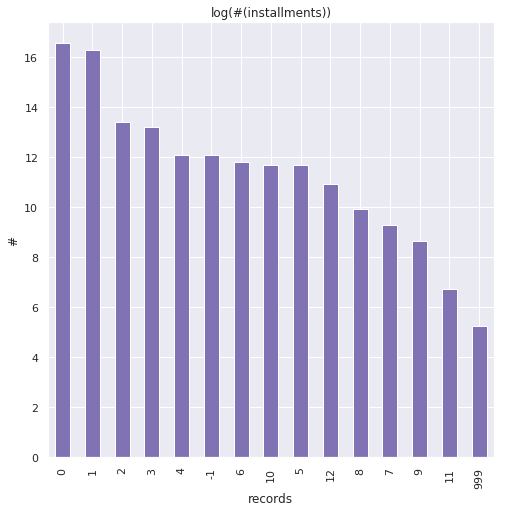

In [44]:
fig,axes = plt.subplots(1,1,figsize=(8,8))
axes.set_title("log(#(installments))")
axes.set_ylabel("#")
axes.set_xlabel("records")
np.log(df_hist_trans.installments.value_counts()).plot(kind="bar",color="m")

#### 3.2.3 Feature Analysis

Next, we want to split the column purchase_date of history_transactions into year, month, day and hour because we have learned that this might improve our model performance later on.

In [45]:
df_hist_trans.dtypes

authorized_flag                 object
card_id                         object
city_id                          int16
category_1                      object
installments                     int16
category_3                      object
merchant_category_id             int16
merchant_id                     object
month_lag                         int8
purchase_amount                float32
purchase_date           datetime64[ns]
category_2                     float16
state_id                          int8
subsector_id                      int8
dtype: object

In [46]:
from datetime import datetime
df_hist_trans["year"] = df_hist_trans["purchase_date"].dt.year
df_hist_trans["month"] = df_hist_trans["purchase_date"].dt.month
df_hist_trans["day"] = df_hist_trans["purchase_date"].dt.day
df_hist_trans["hour"] = df_hist_trans["purchase_date"].dt.hour

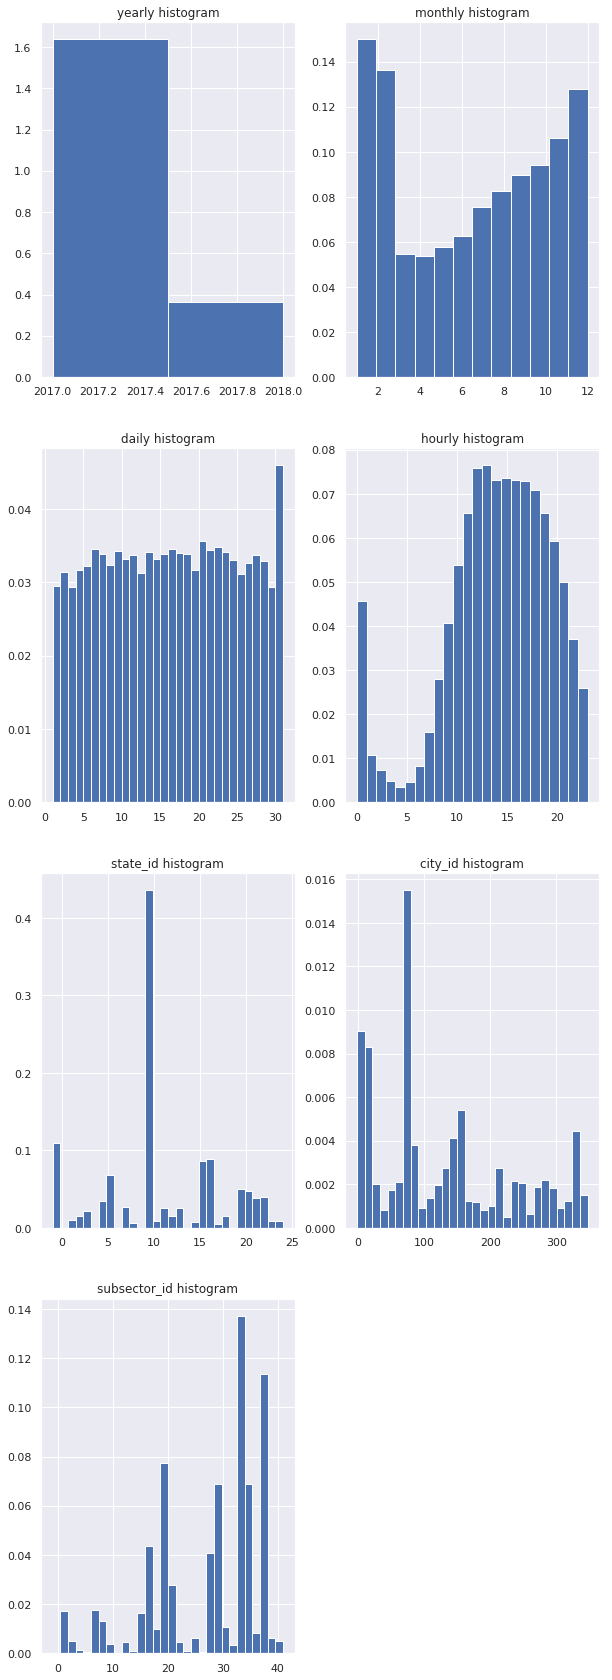

In [47]:
fig,axes = plt.subplots(4,2,figsize=(10,30))
axes[0][0].set_title("yearly histogram")
axes[0][1].set_title("monthly histogram")
axes[1][0].set_title("daily histogram")
axes[1][1].set_title("hourly histogram")
axes[2][0].set_title("state_id histogram")
axes[2][1].set_title("city_id histogram")
axes[3][0].set_title("subsector_id histogram")
axes[3][1].remove()

df_hist_trans.year.hist(ax=axes[0][0],normed=True,bins=2)
df_hist_trans.month.hist(ax=axes[0][1],normed=True,bins=12)
df_hist_trans.day.hist(ax=axes[1][0],normed=True,bins=30)
df_hist_trans.hour.hist(ax=axes[1][1],normed=True,bins=24)
df_hist_trans["state_id"].hist( bins=30,normed=True,ax=axes[2][0])
df_hist_trans["city_id"].hist( bins=30,normed=True,ax=axes[2][1])
df_hist_trans["subsector_id"].hist( bins=30,normed=True,ax=axes[3][0])

Although the daily histogram reveals that there is a uniform distribution for the historical data the hourly histogram shows that it could be useful data for our competition goal. City id, state id and also the subsector_id have an acceptable entropy and they may have considerable potential for enhacing the accuracy of model we want to fit later on.

The new_merchants dataset has the same columns as historical_transactions, therefore we decided to continue with Data Preprocessing in the next chapter and not analyze the new_merchant file separately.

## 4. Data Preprocessing

The data preprocessing was initiated with the history_transactions file.

In [48]:
df_hist_trans.head()

authorized_flag          card_id  city_id category_1  installments  \
0               Y  C_ID_4e6213e9bc       88          N             0   
1               Y  C_ID_4e6213e9bc       88          N             0   
2               Y  C_ID_4e6213e9bc       88          N             0   
3               Y  C_ID_4e6213e9bc       88          N             0   
4               Y  C_ID_4e6213e9bc       88          N             0   

  category_3  merchant_category_id      merchant_id  month_lag  \
0          A                    80  M_ID_e020e9b302         -8   
1          A                   367  M_ID_86ec983688         -7   
2          A                    80  M_ID_979ed661fc         -6   
3          A                   560  M_ID_e6d5ae8ea6         -5   
4          A                    80  M_ID_e020e9b302        -11   

   purchase_amount       purchase_date  category_2  state_id  subsector_id  \
0        -0.703331 2017-06-25 15:33:07         1.0        16            37   
1        -0.733128 2017-07-15 12:10:45         1.0        16            16   
2        -0.720386 2017-08-09 22:04:29         1.0        16            37   
3        -0.735352 2017-09-02 10:06:26         1.0        16            34   
4        -0.722865 2017-03-10 01:14:19         1.0        16            37   

   year  month  day  hour  
0  2017      6   25    15  
1  2017      7   15    12  
2  2017      8    9    22  
3  2017      9    2    10  
4  2017      3   10     1

Here, we mapped the column authorized_flag to numerical data (Y = 1, N = 0). And we created new features as aggregated data of the columns.

In [49]:
#extracting information from historical_df
import gc;gc.collect()
df_hist_trans['authorized_flag'] = df_hist_trans['authorized_flag'].map({'Y':1, 'N':0})
def aggregate_historical_transactions(history):
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).astype(np.int64) * 1e-9
    
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'city_id': ['nunique'],
        'state_id': ['nunique'],
        'purchase_amount': ['sum', 'median', 'max', 'min', 'std'],
        'installments': ['sum', 'median', 'max', 'min', 'std'],
        'purchase_date': [np.ptp],
        'month_lag': ['min', 'max'],
        'year': ['nunique'],
        'month': ['nunique'],
        'day': ['nunique'],
        'hour': ['nunique'],
        'merchant_category_id': ['nunique'],
        }
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['hist_' + '_'.join(col).strip() 
                           for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='hist_transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

new_history = aggregate_historical_transactions(df_hist_trans)

In [50]:
missing_values(new_history)

You data contains 25 columns and has 0 colums with missing values


Empty DataFrame
Columns: [Total Miss Values, % of miss values]
Index: []

In [51]:
new_history.head()

card_id  hist_transactions_count  hist_authorized_flag_sum  \
0  C_ID_00007093c1                      149                       114   
1  C_ID_0001238066                      123                       120   
2  C_ID_0001506ef0                       66                        62   
3  C_ID_0001793786                      216                       189   
4  C_ID_000183fdda                      144                       137   

   hist_authorized_flag_mean  hist_merchant_id_nunique  hist_city_id_nunique  \
0                   0.765101                        29                     4   
1                   0.975610                        65                    18   
2                   0.939394                        28                     3   
3                   0.875000                       119                    10   
4                   0.951389                        73                     9   

   hist_state_id_nunique  hist_purchase_amount_sum  \
0                      3                -76.845039   
1                      6                -72.447197   
2                      2                -34.601879   
3                      4                -36.786011   
4                      7                -68.837936   

   hist_purchase_amount_median  hist_purchase_amount_max  \
0                    -0.587627                  1.507069   
1                    -0.648184                  0.768095   
2                    -0.703707                  1.493545   
3                    -0.487911                  4.554145   
4                    -0.661294                  2.764788   

                 ...                  hist_installments_min  \
0                ...                                      1   
1                ...                                     -1   
2                ...                                      0   
3                ...                                      0   
4                ...                                     -1   

   hist_installments_std  hist_purchase_date_ptp  hist_month_lag_min  \
0               0.764900              32627654.0                 -12   
1               1.485637              13110825.0                  -5   
2               0.123091              34460275.0                 -13   
3               0.150723              24487497.0                  -9   
4               2.118846              17492874.0                  -6   

   hist_month_lag_max  hist_year_nunique  hist_month_nunique  \
0                   0                  2                  12   
1                   0                  2                   6   
2                   0                  2                  11   
3                   0                  1                  10   
4                   0                  2                   7   

   hist_day_nunique  hist_hour_nunique  hist_merchant_category_id_nunique  
0                28                 18                                 18  
1                30                 20                                 29  
2                25                 15                                 19  
3                31                 21                                 48  
4                30                 19                                 36  

[5 rows x 25 columns]

The same process as before was applied for the new_merchants dataset.

In [52]:
df_new_merchant_trans['authorized_flag'] = df_new_merchant_trans['authorized_flag'].map({'Y':1, 'N':0})
def aggregate_new_transactions(new_trans):    
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'merchant_id': ['nunique'],
        'city_id': ['nunique'],
        'purchase_amount': ['sum', 'median', 'max', 'min', 'std'],
        'installments': ['sum', 'median', 'max', 'min', 'std'],
        'month_lag': ['min', 'max'],
        'subsector_id':['nunique'],
        'state_id':['nunique']
        }
    agg_new_trans = new_trans.groupby(['card_id']).agg(agg_func)
    agg_new_trans.columns = ['new_' + '_'.join(col).strip() 
                           for col in agg_new_trans.columns.values]
    agg_new_trans.reset_index(inplace=True)
    
    df = (new_trans.groupby('card_id')
          .size()
          .reset_index(name='new_transactions_count'))
    
    agg_new_trans = pd.merge(df, agg_new_trans, on='card_id', how='left')
    
    return agg_new_trans

new_merchants = aggregate_new_transactions(df_new_merchant_trans)

In [53]:
missing_values(new_merchants)

You data contains 20 columns and has 2 colums with missing values


Total Miss Values  % of miss values
new_purchase_amount_std              43010             14.83
new_installments_std                 43010             14.83

In [54]:
new_merchants.head()

card_id  new_transactions_count  new_authorized_flag_sum  \
0  C_ID_00007093c1                       2                        2   
1  C_ID_0001238066                      26                       26   
2  C_ID_0001506ef0                       2                        2   
3  C_ID_0001793786                      31                       31   
4  C_ID_000183fdda                      11                       11   

   new_authorized_flag_mean  new_merchant_id_nunique  new_city_id_nunique  \
0                         1                        2                    2   
1                         1                       25                    8   
2                         1                        1                    1   
3                         1                       31                    7   
4                         1                       11                    2   

   new_purchase_amount_sum  new_purchase_amount_median  \
0                -1.328125                   -0.664062   
1               -14.851562                   -0.649414   
2                -1.447266                   -0.723633   
3                -0.229004                   -0.372803   
4                -6.589844                   -0.665527   

   new_purchase_amount_max  new_purchase_amount_min  new_purchase_amount_std  \
0                -0.656738                -0.671875                 0.010704   
1                -0.078308                -0.740723                 0.173462   
2                -0.715332                -0.731934                 0.011742   
3                 3.130859                -0.737793                 0.947266   
4                -0.107666                -0.732422                 0.182861   

   new_installments_sum  new_installments_median  new_installments_max  \
0                     2                      1.0                     1   
1                    42                      1.0                    10   
2                     0                      0.0                     0   
3                     0                      0.0                     0   
4                    16                      1.0                     4   

   new_installments_min  new_installments_std  new_month_lag_min  \
0                     1              0.000000                  2   
1                    -1              2.079941                  1   
2                     0              0.000000                  1   
3                     0              0.000000                  1   
4                    -1              1.293340                  1   

   new_month_lag_max  new_subsector_id_nunique  new_state_id_nunique  
0                  2                         2                     2  
1                  2                         9                     4  
2                  1                         2                     1  
3                  2                        14                     5  
4                  2                         6                     2

There is some missing values, which we can not drop totally, because they almost comprise 15% of the column. We will check the distribution without missing values and replace them with the mean as one options of how to deal with missing values.

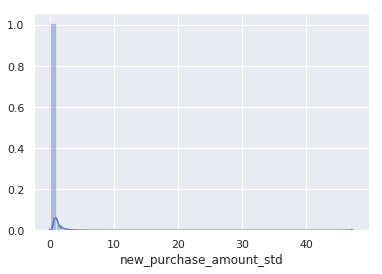

In [55]:
sns.distplot(new_merchants['new_purchase_amount_std'].dropna())

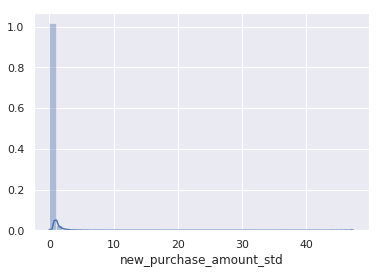

In [56]:
sns.distplot(new_merchants['new_purchase_amount_std'].fillna(new_merchants['new_purchase_amount_std'].mean()))

It has the same distribution, hence it is possible to replace missing values with the mean.

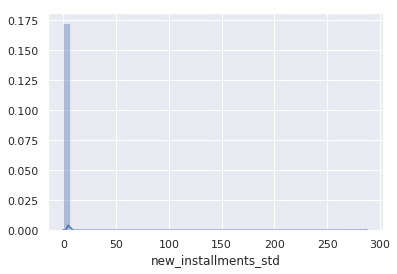

In [57]:
sns.distplot(new_merchants['new_installments_std'].dropna())

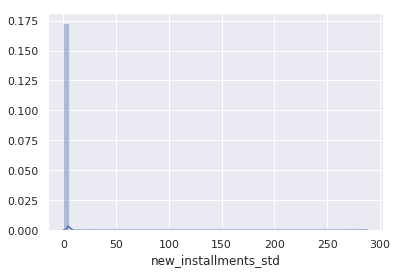

In [58]:
sns.distplot(new_merchants['new_installments_std'].fillna(new_merchants['new_installments_std'].mean()))

In [59]:
new_merchants['new_purchase_amount_std'] = new_merchants['new_purchase_amount_std'].fillna(new_merchants['new_purchase_amount_std'].mean())
new_merchants['new_installments_std'] = new_merchants['new_installments_std'].fillna(new_merchants['new_installments_std'].mean())
missing_values(new_merchants)

You data contains 20 columns and has 0 colums with missing values


Empty DataFrame
Columns: [Total Miss Values, % of miss values]
Index: []

2018.02.01 is the last date in the dataset. We will calculate the difference of each date and create new features from these calculations.

In [60]:
from datetime import datetime
df_train['elapsed_time'] = (datetime(2018, 2, 1) - df_train['first_active_month']).dt.days
df_test['elapsed_time'] = (datetime(2018, 2, 1) - df_test['first_active_month']).dt.days

In [61]:
df_train.head()

first_active_month          card_id  feature_1  feature_2  feature_3  \
0         2017-06-01  C_ID_92a2005557          5          2          1   
1         2017-01-01  C_ID_3d0044924f          4          1          0   
2         2016-08-01  C_ID_d639edf6cd          2          2          0   
3         2017-09-01  C_ID_186d6a6901          4          3          0   
4         2017-11-01  C_ID_cdbd2c0db2          1          3          0   

     target  elapsed_time  
0 -0.820312           245  
1  0.392822           396  
2  0.687988           549  
3  0.142456           153  
4 -0.159790            92

In [62]:
df_test.head()

first_active_month          card_id  feature_1  feature_2  feature_3  \
0         2017-04-01  C_ID_0ab67a22ab          3          3          1   
1         2017-01-01  C_ID_130fd0cbdd          2          3          0   
2         2017-08-01  C_ID_b709037bc5          5          1          1   
3         2017-12-01  C_ID_d27d835a9f          2          1          0   
4         2015-12-01  C_ID_2b5e3df5c2          5          1          1   

   elapsed_time  
0           306  
1           396  
2           184  
3            62  
4           793

Now we can merge the train data with historical_transactions and new_merchants. The same operations has been applied for the test data.

In [63]:
df_train = pd.merge(df_train, new_history, on='card_id', how='left')
df_test = pd.merge(df_test, new_history, on='card_id', how='left')

df_train = pd.merge(df_train, new_merchants, on='card_id', how='left')
df_test = pd.merge(df_test, new_merchants, on='card_id', how='left')

In [64]:
df_train.shape, df_test.shape

((201917, 50), (123623, 49))

In [65]:
missing_values(df_train)

You data contains 50 columns and has 19 colums with missing values


Total Miss Values  % of miss values
new_transactions_count                  21931             10.86
new_installments_sum                    21931             10.86
new_subsector_id_nunique                21931             10.86
new_month_lag_max                       21931             10.86
new_month_lag_min                       21931             10.86
new_installments_std                    21931             10.86
new_installments_min                    21931             10.86
new_installments_max                    21931             10.86
new_installments_median                 21931             10.86
new_purchase_amount_std                 21931             10.86
new_authorized_flag_sum                 21931             10.86
new_purchase_amount_min                 21931             10.86
new_purchase_amount_max                 21931             10.86
new_purchase_amount_median              21931             10.86
new_purchase_amount_sum                 21931             10.86
new_city_id_nunique                     21931             10.86
new_merchant_id_nunique                 21931             10.86
new_authorized_flag_mean                21931             10.86
new_state_id_nunique                    21931             10.86

In the next cell we used LabelEncoder to deal with categorical variables. The LabelEncodder encodes labels with a value between 0 and n_classes-1 where n is the number of distinct labels. If a label repeats in the column it gets assigned the same value it has been as assigned earlier due to the learning process. We decided to not use One Hot Encoding (dummy variables) because we preferred to not create additional dummy columns / variables. 

In [66]:
# Categorizing feature_1 & feature_2 & feature_3
from sklearn.preprocessing import LabelEncoder
for col in ["feature_1", "feature_2","feature_3"]:
#     print(col)
    lbl = LabelEncoder()
    lbl.fit(list(df_train[col].values.astype('str')) + list(df_test[col].values.astype('str')))
    df_train[col] = lbl.transform(list(df_train[col].values.astype('str')))
    df_test[col] = lbl.transform(list(df_test[col].values.astype('str')))

We then dropped columns with low importance.

In [67]:
df_train = df_train.drop(['first_active_month', 'card_id'], axis=1)
df_train.head()

feature_1  feature_2  feature_3    target  elapsed_time  \
0          4          1          1 -0.820312           245   
1          3          0          0  0.392822           396   
2          1          1          0  0.687988           549   
3          3          2          0  0.142456           153   
4          0          2          0 -0.159790            92   

   hist_transactions_count  hist_authorized_flag_sum  \
0                      260                       247   
1                      350                       339   
2                       43                        41   
3                       77                        77   
4                      133                       128   

   hist_authorized_flag_mean  hist_merchant_id_nunique  hist_city_id_nunique  \
0                   0.950000                        94                     7   
1                   0.968571                       142                     9   
2                   0.953488                        13                     5   
3                   1.000000                        50                     7   
4                   0.962406                        66                     6   

           ...           new_purchase_amount_std  new_installments_sum  \
0          ...                          0.135742                   0.0   
1          ...                          0.014381                   6.0   
2          ...                          0.000000                   0.0   
3          ...                          0.065918                   5.0   
4          ...                          0.223877                  35.0   

   new_installments_median  new_installments_max  new_installments_min  \
0                      0.0                   0.0                   0.0   
1                      1.0                   1.0                   1.0   
2                      0.0                   0.0                   0.0   
3                      1.0                   1.0                  -1.0   
4                      1.0                   2.0                  -1.0   

   new_installments_std  new_month_lag_min  new_month_lag_max  \
0              0.000000                1.0                2.0   
1              0.000000                1.0                2.0   
2              0.522499                2.0                2.0   
3              0.755929                1.0                2.0   
4              0.376913                1.0                2.0   

   new_subsector_id_nunique  new_state_id_nunique  
0                      10.0                   1.0  
1                       4.0                   1.0  
2                       1.0                   1.0  
3                       5.0                   2.0  
4                      10.0                   5.0  

[5 rows x 48 columns]

The same was done for the test data, but we decided to save the card_id of the test data to use it for the submission and then only to drop it.

In [68]:
df_test = df_test.drop(['first_active_month'], axis=1)


In [69]:
df_card = pd.DataFrame()
df_card['card_id'] = df_test['card_id']
df_card.head()

card_id
0  C_ID_0ab67a22ab
1  C_ID_130fd0cbdd
2  C_ID_b709037bc5
3  C_ID_d27d835a9f
4  C_ID_2b5e3df5c2

In [70]:
df_test = df_test.drop(['card_id'], axis=1)

In [71]:
df_train.shape, df_test.shape

((201917, 48), (123623, 47))

## 5. Data Cleaning

After merging datasets, there are a lot of columns with missing values. As we did before we will check the distribution and replace them with different values. In the coming cells we first replaced missing values with the mean, other columns with the median and finally with the minimun value. In a first step this procedure was applied to the train data, afterwards to the test data.

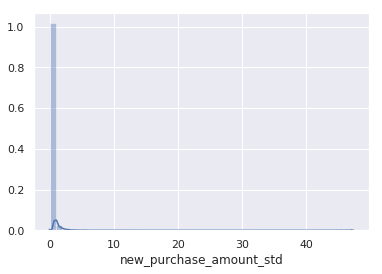

In [72]:
sns.distplot(df_train['new_purchase_amount_std'].dropna())

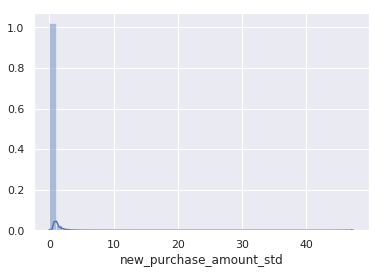

In [73]:
sns.distplot(df_train['new_purchase_amount_std'].fillna(df_train['new_purchase_amount_std'].mean()))

In [74]:
# Fill with mean
def fill_mean(df):
    mean_col = ['new_purchase_amount_std','new_installments_std' ,
     'new_installments_sum','new_installments_max','new_installments_median']
    for col in mean_col:
        df[col] = df[col].fillna(df[col].mean())
        
fill_mean(df_train)

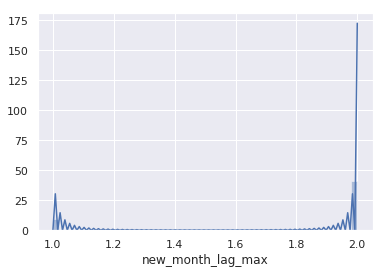

In [75]:
sns.distplot(df_train['new_month_lag_max'].dropna())

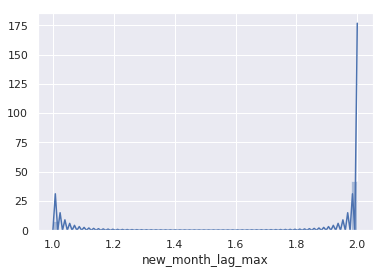

In [76]:
sns.distplot(df_train['new_month_lag_max'].fillna(df_train['new_month_lag_max'].median()))

In [77]:
# Fill with median
def fill_median(df):
    median_col = ['new_month_lag_max','new_month_lag_min','new_installments_min','new_purchase_amount_min',
                'new_purchase_amount_max','new_purchase_amount_median','new_purchase_amount_sum']
    for col in median_col:
        df[col] = df[col].fillna(df[col].median())
        
fill_median(df_train)


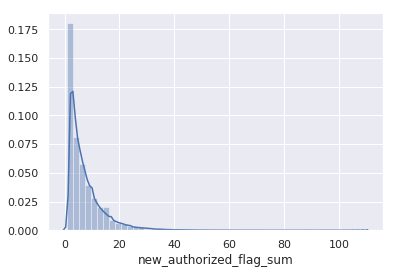

In [78]:
sns.distplot(df_train['new_authorized_flag_sum'].dropna())

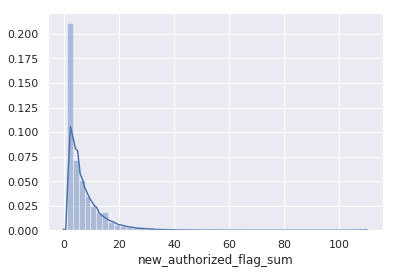

In [79]:
sns.distplot(df_train['new_authorized_flag_sum'].fillna(df_train['new_authorized_flag_sum'].min()))

In [80]:
# Fill with min
def fill_min(df):
    min_col = 'new_authorized_flag_sum','new_merchant_id_nunique','new_state_id_nunique',
    'new_transactions_count','new_subsector_id_nunique','new_city_id_nunique',
    'new_authorized_flag_mean'
    for col in min_col:
        df[col] = df[col].fillna(df[col].min())
        
fill_min(df_train)
missing_values(df_train)

You data contains 48 columns and has 4 colums with missing values


Total Miss Values  % of miss values
new_transactions_count                21931             10.86
new_authorized_flag_mean              21931             10.86
new_city_id_nunique                   21931             10.86
new_subsector_id_nunique              21931             10.86

Unfortunately, for some columns the previous function did not replace the missing values, so we had to change this manually as highlighted below.

In [81]:
df_train['new_transactions_count'] = df_train['new_transactions_count'].fillna(df_train['new_transactions_count'].min())
df_train['new_authorized_flag_mean'] = df_train['new_authorized_flag_mean'].fillna(df_train['new_authorized_flag_mean'].min())
df_train['new_city_id_nunique'] = df_train['new_city_id_nunique'].fillna(df_train['new_city_id_nunique'].min())
df_train['new_subsector_id_nunique'] = df_train['new_subsector_id_nunique'].fillna(df_train['new_subsector_id_nunique'].min())

missing_values(df_train)

You data contains 48 columns and has 0 colums with missing values


Empty DataFrame
Columns: [Total Miss Values, % of miss values]
Index: []

The same procedure was then applied to the test data.

In [82]:
# REPEAT THE SAME FOR THE TEST SET
def fill_test(df):
    mean_col = ['new_purchase_amount_std','new_installments_std' ,
     'new_installments_sum','new_installments_max','new_installments_median']
    for col in mean_col:
        df[col] = df[col].fillna(df[col].mean())
    
    median_col = ['new_month_lag_max','new_month_lag_min','new_installments_min','new_purchase_amount_min',
                'new_purchase_amount_max','new_purchase_amount_median','new_purchase_amount_sum']
    for col in median_col:
        df[col] = df[col].fillna(df[col].median())
    
    min_col = 'new_authorized_flag_sum','new_merchant_id_nunique','new_state_id_nunique',
    'new_transactions_count','new_subsector_id_nunique','new_city_id_nunique',
    'new_authorized_flag_mean'
    for col in min_col:
        df[col] = df[col].fillna(df[col].min())
        
fill_test(df_test)

In [83]:
df_test['new_transactions_count'] = df_test['new_transactions_count'].fillna(df_test['new_transactions_count'].min())
df_test['new_authorized_flag_mean'] = df_test['new_authorized_flag_mean'].fillna(df_test['new_authorized_flag_mean'].min())
df_test['new_city_id_nunique'] = df_test['new_city_id_nunique'].fillna(df_test['new_city_id_nunique'].min())
df_test['new_subsector_id_nunique'] = df_test['new_subsector_id_nunique'].fillna(df_test['new_subsector_id_nunique'].min())

missing_values(df_test)

You data contains 47 columns and has 0 colums with missing values


Empty DataFrame
Columns: [Total Miss Values, % of miss values]
Index: []

Now, the data was prepared in order to create our models as the next chapter will show.

## 6. Models

As the underlying models we used Linear Regression, Ridge Regression, Lasso Regression, Decision Tree Regressor as well as Random Forest to fit our train data and predict on the test dataset. All approaches will be shown in more detail in this chapter. We decided to use these models to see how our model performs under different regression scenarios as well as different tree techniques and whether we can see a dominant distinction.

In [84]:
y = df_train.target
X = df_train.drop(['target'],axis=1)

In [85]:
missing_values(df_train)

You data contains 48 columns and has 0 colums with missing values


Empty DataFrame
Columns: [Total Miss Values, % of miss values]
Index: []

There is no target in the test dataset, therefore for prechecking the RMSE for each model, we decided to split the train data as the next cell emphasizes.

In [86]:
#Import train_test_split from sklearn.model_selection to split data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
missing_values(df_test)

You data contains 47 columns and has 0 colums with missing values


Empty DataFrame
Columns: [Total Miss Values, % of miss values]
Index: []

### 6.1 Linear Regression

Linear regression is a basic technique that makes sense for a first simple model. The simple function is Y = a + bX + ϵ. Linear Regression is a good step to achieve results quickly with a simple model.

In [88]:
#Import the relevant package of sklearn.linear_model
from sklearn.linear_model import LinearRegression

# Fit the model with X_train and y_train and predict y_pred
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_val)

In [89]:
#Import other packages to perform cross-validation and calculate the estimated RMSE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Calculate the cross_val_score
cv_reg = cross_val_score(reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-cv_reg)
print(rmse_scores)
print('Mean RMSE:',rmse_scores.mean())


[3.80616932 3.76066774 3.79494105 3.83931928 4.03689452 3.69777142
 3.658832   3.6010521  3.73986741 3.78149195]
Mean RMSE: 3.77170067916438


### 6.2 Ridge Regression

Ridge Regression is another technique that we applied. In general it is useful to analyze multiple regression data with multicollinearity problems. 

In [90]:
#Import relevant packages for Ridge Regression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

alphas = np.array([1,0.1,0.01,0.001,0.0001,0])

# Do GridSearchCV to find the best params
ridge = Ridge()
cv_ridge = GridSearchCV(estimator=ridge, param_grid=dict(alpha=alphas), cv=5)
cv_ridge.fit(X_train, y_train)
print(cv_ridge.best_params_)

{'alpha': 0.0001}


In [91]:
#Apply the best alpha found by GridSearchCV
ridge_new = Ridge(alpha=0.0001)
ridge_new.fit(X_train, y_train)
y_ridge_pred = ridge_new.predict(X_val)
print('RMSE: ', np.sqrt(mean_squared_error(y_val, y_ridge_pred)))
print('R-square: ', r2_score(y_val, y_ridge_pred))

RMSE:  3.79790929669516
R-square:  0.03975723539479259


### 6.3 Lasso Regression

The Lasso regression is the third regression method we applied. Generally it helps to shrink and select variables for linear regression models.

In [92]:
#Import the relevant packages
from sklearn.linear_model import Lasso

#Do GridSearchCV to find the best params
lasso = Lasso()
alphas = np.array([0.01, 0.1, 1, 10])
cv_lasso = GridSearchCV(lasso, param_grid=dict(alpha=alphas), cv=3)
cv_lasso.fit(X_train, y_train)
cv_lasso.best_params_

{'alpha': 0.01}

In [93]:
#Apply the best alpha found by GridSearchCV
lasso_new = Lasso(alpha=0.01)
lasso_new.fit(X_train, y_train)
y_lasso_pred = lasso_new.predict(X_val)
print('RMSE: ', np.sqrt(mean_squared_error(y_val, y_lasso_pred)))
print('R-square: ', r2_score(y_val, y_lasso_pred))

RMSE:  3.798305282321537
R-square:  0.03955698724470613


 ### 6.4 Decision Tree Regressor

In Regression Trees target feature values can now take on an infinite number of continuously scaled values. Therefore we decided to apply the DecisionTreeRegressor as shown below.

In [94]:
#Import the relevant packages and fit the data
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

dt = DecisionTreeRegressor(max_depth=4,
                           min_samples_split=5,
                           max_leaf_nodes=10,
                            random_state=42)
dt.fit(X_train, y_train)
y_val_pred = dt.predict(X_val)
print('RMSE: ', np.sqrt(mean_squared_error(y_val, y_val_pred)))
print('R-square: ', r2_score(y_val, y_val_pred))

RMSE:  3.7900860916515033
R-square:  0.04370911438628766


Similarly as in the previos models, we wanted to tune the parameters with Grid Search Cross Validation. Cross-validation is a method for robustly estimating the test-set performance (generalization) of our model. 

In [95]:
# Apply GridSearchCV to find best params
from sklearn.model_selection import GridSearchCV


param_grid = {"criterion": ["mse"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100],
              }

grid_cv_dtm = GridSearchCV(dt, param_grid, cv=5)

grid_cv_dtm.fit(X_train,y_train)



GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=10, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['mse'], 'min_samples_split': [10, 20, 40], 'max_depth': [2, 6, 8], 'min_samples_leaf': [20, 40, 100], 'max_leaf_nodes': [5, 20, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [96]:
print("Best Hyperparameters::\n{}".format(grid_cv_dtm.best_params_))

Best Hyperparameters::
{'criterion': 'mse', 'max_depth': 6, 'max_leaf_nodes': 100, 'min_samples_leaf': 100, 'min_samples_split': 10}


Next, we could fit the model with the best params we had detected before.

In [97]:
#Fit model with best params
dt2 = DecisionTreeRegressor(max_depth=6,
                           min_samples_split=10,
                           max_leaf_nodes=100,
                           min_samples_leaf=100, 
                           random_state=42)
dt2.fit(X_train, y_train)
y_val_pred_new = dt2.predict(X_val)
print('RMSE: ', np.sqrt(mean_squared_error(y_val, y_val_pred_new)))
print('R-square: ', r2_score(y_val, y_val_pred_new))

RMSE:  3.7655548302582855
R-square:  0.056048202247508616


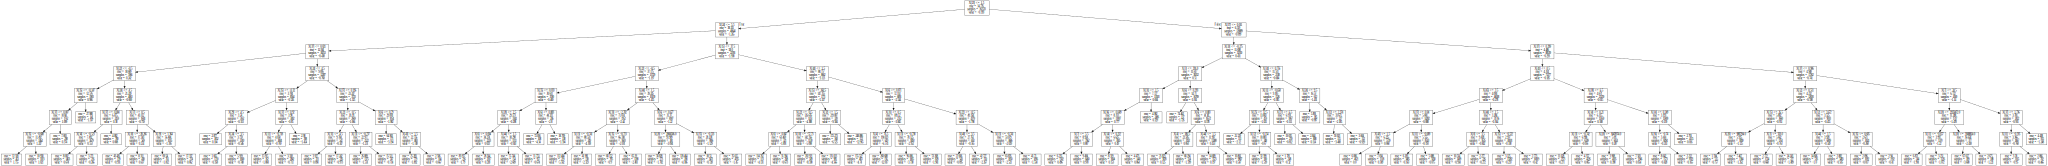

In [110]:
#Visualizing the resulting tree with the graphviz package
from sklearn.tree import export_graphviz
import graphviz
#import pydot
from IPython.display import Image
from sklearn import tree

dot_data = tree.export_graphviz(dt2, out_file=None)  
graph = graphviz.Source(dot_data)  
graph

### 6.5 Random Forest

As a last model we applied Random Forest and first fitted the model with sample params values. We generated different models each time with different params that we selected to fit our data.

In [99]:
#Import the relevant packages and fit the model
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(bootstrap=True,
                           max_depth=4,
                           min_samples_split=5,
                           max_leaf_nodes=10,
                            random_state=42)

rf.fit(X_train, y_train)
y_rf_pred = dt.predict(X_val)
print('RMSE: ', np.sqrt(mean_squared_error(y_val, y_rf_pred)))
print('R-square: ', r2_score(y_val, y_rf_pred))

RMSE:  3.7900860916515033
R-square:  0.04370911438628766


In order to tune the params we used Randomized Search Cross Validation as shown in the next cell.

In [100]:
#Import the relevant package
from sklearn.model_selection import RandomizedSearchCV

# Criterion
criterion = ['mse']
# Number of trees in random forest
n_estimators = [int(x) for x in np.arange(start = 2 , stop = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [2,6,8]
# Minimum number of samples required to split a node
min_samples_split = [10, 20, 40]
# Minimum number of samples required at each leaf node
min_samples_leaf = [20, 40, 100]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Maximum leaf nodes
max_leaf_nodes = [5, 20, 100]

# Create the random grid
random_grid = {'criterion' : criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'max_leaf_nodes': max_leaf_nodes
              }

In [101]:
#Model 2
#Perform RandomizedSearchCV with defined criteria
rf2 = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf2, param_distributions = random_grid, 
                n_iter = 100, cv = 5, verbose=2, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] n_estimators=4, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=5, max_features=sqrt, max_depth=2, criterion=mse, bootstrap=False 
[CV] n_estimators=4, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=5, max_features=sqrt, max_depth=2, criterion=mse, bootstrap=False 
[CV] n_estimators=4, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=5, max_features=sqrt, max_depth=2, criterion=mse, bootstrap=False 
[CV] n_estimators=4, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=5, max_features=sqrt, max_depth=2, criterion=mse, bootstrap=False 
[CV] n_estimators=4, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=5, max_features=sqrt, max_depth=2, criterion=mse, bootstrap=False 
[CV] n_estimators=7, min_samples_split=10, min_samples_leaf=20, max_leaf_nodes=20, max_features=sqrt, max_depth=8, criterion=mse, bootstrap=True 
[CV] n_estimators=7, min_samples_split=10, min_samples_l

[CV] n_estimators=4, min_samples_split=40, min_samples_leaf=40, max_leaf_nodes=100, max_features=sqrt, max_depth=8, criterion=mse, bootstrap=False 
[CV]  n_estimators=2, min_samples_split=10, min_samples_leaf=20, max_leaf_nodes=20, max_features=sqrt, max_depth=2, criterion=mse, bootstrap=True, total=   0.3s
[CV] n_estimators=4, min_samples_split=40, min_samples_leaf=40, max_leaf_nodes=100, max_features=sqrt, max_depth=8, criterion=mse, bootstrap=False 
[CV]  n_estimators=2, min_samples_split=10, min_samples_leaf=20, max_leaf_nodes=20, max_features=sqrt, max_depth=2, criterion=mse, bootstrap=True, total=   0.3s
[CV] n_estimators=4, min_samples_split=40, min_samples_leaf=40, max_leaf_nodes=100, max_features=sqrt, max_depth=8, criterion=mse, bootstrap=False 
[CV] n_estimators=4, min_samples_split=40, min_samples_leaf=40, max_leaf_nodes=100, max_features=sqrt, max_depth=8, criterion=mse, bootstrap=False 
[CV] n_estimators=6, min_samples_split=10, min_samples_leaf=40, max_leaf_nodes=100, ma

[CV] n_estimators=8, min_samples_split=10, min_samples_leaf=100, max_leaf_nodes=5, max_features=auto, max_depth=8, criterion=mse, bootstrap=False 
[CV]  n_estimators=8, min_samples_split=40, min_samples_leaf=40, max_leaf_nodes=5, max_features=sqrt, max_depth=2, criterion=mse, bootstrap=False, total=   1.1s
[CV] n_estimators=8, min_samples_split=10, min_samples_leaf=100, max_leaf_nodes=5, max_features=auto, max_depth=8, criterion=mse, bootstrap=False 
[CV]  n_estimators=8, min_samples_split=40, min_samples_leaf=40, max_leaf_nodes=5, max_features=sqrt, max_depth=2, criterion=mse, bootstrap=False, total=   1.0s
[CV] n_estimators=8, min_samples_split=10, min_samples_leaf=100, max_leaf_nodes=5, max_features=auto, max_depth=8, criterion=mse, bootstrap=False 
[CV]  n_estimators=8, min_samples_split=40, min_samples_leaf=40, max_leaf_nodes=5, max_features=sqrt, max_depth=2, criterion=mse, bootstrap=False, total=   1.0s
[CV]  n_estimators=8, min_samples_split=40, min_samples_leaf=40, max_leaf_no

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    7.1s


[CV] n_estimators=9, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=5, max_features=auto, max_depth=2, criterion=mse, bootstrap=True 
[CV] n_estimators=9, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=5, max_features=auto, max_depth=2, criterion=mse, bootstrap=True 
[CV] n_estimators=9, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=5, max_features=auto, max_depth=2, criterion=mse, bootstrap=True 
[CV] n_estimators=7, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=20, max_features=auto, max_depth=2, criterion=mse, bootstrap=True 
[CV] n_estimators=7, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=20, max_features=auto, max_depth=2, criterion=mse, bootstrap=True 
[CV] n_estimators=7, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=20, max_features=auto, max_depth=2, criterion=mse, bootstrap=True 
[CV] n_estimators=7, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=20, max_features=auto, max_depth=2, crite

[CV]  n_estimators=6, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=5, max_features=sqrt, max_depth=6, criterion=mse, bootstrap=True, total=   0.7s
[CV] n_estimators=9, min_samples_split=10, min_samples_leaf=40, max_leaf_nodes=100, max_features=auto, max_depth=2, criterion=mse, bootstrap=True 
[CV] n_estimators=9, min_samples_split=10, min_samples_leaf=40, max_leaf_nodes=100, max_features=auto, max_depth=2, criterion=mse, bootstrap=True 
[CV] n_estimators=9, min_samples_split=10, min_samples_leaf=40, max_leaf_nodes=100, max_features=auto, max_depth=2, criterion=mse, bootstrap=True 
[CV] n_estimators=9, min_samples_split=40, min_samples_leaf=40, max_leaf_nodes=20, max_features=sqrt, max_depth=8, criterion=mse, bootstrap=True 
[CV]  n_estimators=3, min_samples_split=40, min_samples_leaf=40, max_leaf_nodes=100, max_features=sqrt, max_depth=6, criterion=mse, bootstrap=False, total=   0.9s
[CV] n_estimators=9, min_samples_split=40, min_samples_leaf=40, max_leaf_nodes=20, max_fe

[CV] n_estimators=7, min_samples_split=20, min_samples_leaf=40, max_leaf_nodes=5, max_features=sqrt, max_depth=6, criterion=mse, bootstrap=False 
[CV]  n_estimators=9, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=5, max_features=auto, max_depth=2, criterion=mse, bootstrap=True, total=   6.3s
[CV]  n_estimators=9, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=5, max_features=auto, max_depth=2, criterion=mse, bootstrap=True, total=   5.9s
[CV]  n_estimators=4, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=100, max_features=sqrt, max_depth=6, criterion=mse, bootstrap=False, total=   1.3s
[CV]  n_estimators=4, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=100, max_features=sqrt, max_depth=6, criterion=mse, bootstrap=False, total=   1.2s
[CV] n_estimators=7, min_samples_split=20, min_samples_leaf=40, max_leaf_nodes=5, max_features=sqrt, max_depth=6, criterion=mse, bootstrap=False 
[CV]  n_estimators=9, min_samples_split=40, min_samples_le

[CV]  n_estimators=3, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=5, max_features=auto, max_depth=8, criterion=mse, bootstrap=True, total=   1.7s
[CV]  n_estimators=9, min_samples_split=10, min_samples_leaf=40, max_leaf_nodes=100, max_features=auto, max_depth=2, criterion=mse, bootstrap=True, total=   5.9s
[CV] n_estimators=2, min_samples_split=20, min_samples_leaf=100, max_leaf_nodes=20, max_features=auto, max_depth=2, criterion=mse, bootstrap=False 
[CV]  n_estimators=3, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=5, max_features=auto, max_depth=8, criterion=mse, bootstrap=True, total=   2.0s
[CV]  n_estimators=3, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=5, max_features=auto, max_depth=8, criterion=mse, bootstrap=True, total=   1.8s
[CV] n_estimators=3, min_samples_split=40, min_samples_leaf=20, max_leaf_nodes=100, max_features=sqrt, max_depth=8, criterion=mse, bootstrap=True 
[CV] n_estimators=3, min_samples_split=40, min_samples_leaf=

[CV]  n_estimators=3, min_samples_split=20, min_samples_leaf=100, max_leaf_nodes=100, max_features=auto, max_depth=8, criterion=mse, bootstrap=False, total=   6.7s
[CV]  n_estimators=5, min_samples_split=20, min_samples_leaf=100, max_leaf_nodes=20, max_features=sqrt, max_depth=6, criterion=mse, bootstrap=False, total=   1.0s
[CV] n_estimators=4, min_samples_split=20, min_samples_leaf=20, max_leaf_nodes=5, max_features=auto, max_depth=6, criterion=mse, bootstrap=True 
[CV]  n_estimators=5, min_samples_split=20, min_samples_leaf=100, max_leaf_nodes=20, max_features=sqrt, max_depth=6, criterion=mse, bootstrap=False, total=   1.0s
[CV]  n_estimators=3, min_samples_split=20, min_samples_leaf=100, max_leaf_nodes=100, max_features=auto, max_depth=8, criterion=mse, bootstrap=False, total=   6.9s
[CV] n_estimators=4, min_samples_split=20, min_samples_leaf=20, max_leaf_nodes=5, max_features=auto, max_depth=6, criterion=mse, bootstrap=True 
[CV] n_estimators=3, min_samples_split=40, min_samples_l

[CV] n_estimators=7, min_samples_split=20, min_samples_leaf=100, max_leaf_nodes=100, max_features=sqrt, max_depth=2, criterion=mse, bootstrap=True 
[CV] n_estimators=3, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=5, max_features=auto, max_depth=2, criterion=mse, bootstrap=False 
[CV]  n_estimators=9, min_samples_split=10, min_samples_leaf=100, max_leaf_nodes=20, max_features=sqrt, max_depth=8, criterion=mse, bootstrap=True, total=   1.8s
[CV] n_estimators=3, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=5, max_features=auto, max_depth=2, criterion=mse, bootstrap=False 
[CV]  n_estimators=7, min_samples_split=10, min_samples_leaf=40, max_leaf_nodes=5, max_features=auto, max_depth=6, criterion=mse, bootstrap=False, total=   7.0s
[CV] n_estimators=3, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=5, max_features=auto, max_depth=2, criterion=mse, bootstrap=False 
[CV]  n_estimators=7, min_samples_split=20, min_samples_leaf=100, max_leaf_nodes=100, ma

[CV] n_estimators=5, min_samples_split=40, min_samples_leaf=40, max_leaf_nodes=5, max_features=sqrt, max_depth=6, criterion=mse, bootstrap=True 
[CV] n_estimators=8, min_samples_split=20, min_samples_leaf=20, max_leaf_nodes=5, max_features=auto, max_depth=6, criterion=mse, bootstrap=True 
[CV]  n_estimators=5, min_samples_split=40, min_samples_leaf=40, max_leaf_nodes=5, max_features=sqrt, max_depth=6, criterion=mse, bootstrap=True, total=   0.5s
[CV] n_estimators=8, min_samples_split=20, min_samples_leaf=20, max_leaf_nodes=5, max_features=auto, max_depth=6, criterion=mse, bootstrap=True 
[CV]  n_estimators=3, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=5, max_features=auto, max_depth=2, criterion=mse, bootstrap=False, total=   3.0s
[CV] n_estimators=8, min_samples_split=20, min_samples_leaf=20, max_leaf_nodes=5, max_features=auto, max_depth=6, criterion=mse, bootstrap=True 
[CV]  n_estimators=5, min_samples_split=40, min_samples_leaf=40, max_leaf_nodes=5, max_features=sq

[CV]  n_estimators=5, min_samples_split=20, min_samples_leaf=100, max_leaf_nodes=100, max_features=auto, max_depth=6, criterion=mse, bootstrap=False, total=  10.4s
[CV]  n_estimators=6, min_samples_split=10, min_samples_leaf=20, max_leaf_nodes=100, max_features=auto, max_depth=2, criterion=mse, bootstrap=True, total=   4.0s
[CV] n_estimators=5, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=20, max_features=sqrt, max_depth=2, criterion=mse, bootstrap=True 
[CV]  n_estimators=6, min_samples_split=10, min_samples_leaf=20, max_leaf_nodes=100, max_features=auto, max_depth=2, criterion=mse, bootstrap=True, total=   4.2s
[CV] n_estimators=5, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=20, max_features=sqrt, max_depth=2, criterion=mse, bootstrap=True 
[CV] n_estimators=5, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=20, max_features=sqrt, max_depth=2, criterion=mse, bootstrap=True 
[CV]  n_estimators=2, min_samples_split=20, min_samples_leaf=40, max_le

[CV]  n_estimators=8, min_samples_split=20, min_samples_leaf=20, max_leaf_nodes=5, max_features=auto, max_depth=6, criterion=mse, bootstrap=True, total=   6.6s
[CV] n_estimators=9, min_samples_split=10, min_samples_leaf=40, max_leaf_nodes=20, max_features=auto, max_depth=6, criterion=mse, bootstrap=True 
[CV] n_estimators=9, min_samples_split=10, min_samples_leaf=40, max_leaf_nodes=20, max_features=auto, max_depth=6, criterion=mse, bootstrap=True 


[Parallel(n_jobs=-1)]: Done 253 tasks      | elapsed:   32.4s


[CV]  n_estimators=3, min_samples_split=10, min_samples_leaf=100, max_leaf_nodes=5, max_features=auto, max_depth=6, criterion=mse, bootstrap=False, total=   4.2s
[CV] n_estimators=9, min_samples_split=10, min_samples_leaf=40, max_leaf_nodes=20, max_features=auto, max_depth=6, criterion=mse, bootstrap=True 
[CV] n_estimators=9, min_samples_split=10, min_samples_leaf=40, max_leaf_nodes=20, max_features=auto, max_depth=6, criterion=mse, bootstrap=True 
[CV] n_estimators=9, min_samples_split=10, min_samples_leaf=40, max_leaf_nodes=20, max_features=auto, max_depth=6, criterion=mse, bootstrap=True 
[CV]  n_estimators=8, min_samples_split=20, min_samples_leaf=20, max_leaf_nodes=5, max_features=auto, max_depth=6, criterion=mse, bootstrap=True, total=   6.9s
[CV] n_estimators=6, min_samples_split=40, min_samples_leaf=20, max_leaf_nodes=5, max_features=sqrt, max_depth=8, criterion=mse, bootstrap=False 
[CV] n_estimators=6, min_samples_split=40, min_samples_leaf=20, max_leaf_nodes=5, max_features

[CV] n_estimators=9, min_samples_split=40, min_samples_leaf=20, max_leaf_nodes=100, max_features=auto, max_depth=8, criterion=mse, bootstrap=True 
[CV]  n_estimators=9, min_samples_split=20, min_samples_leaf=100, max_leaf_nodes=100, max_features=auto, max_depth=8, criterion=mse, bootstrap=False, total=  22.2s
[CV]  n_estimators=6, min_samples_split=10, min_samples_leaf=100, max_leaf_nodes=5, max_features=sqrt, max_depth=2, criterion=mse, bootstrap=True, total=   0.9s
[CV]  n_estimators=6, min_samples_split=10, min_samples_leaf=100, max_leaf_nodes=5, max_features=sqrt, max_depth=2, criterion=mse, bootstrap=True, total=   0.8s
[CV] n_estimators=9, min_samples_split=40, min_samples_leaf=20, max_leaf_nodes=100, max_features=auto, max_depth=8, criterion=mse, bootstrap=True 
[CV]  n_estimators=6, min_samples_split=10, min_samples_leaf=100, max_leaf_nodes=5, max_features=sqrt, max_depth=2, criterion=mse, bootstrap=True, total=   0.8s
[CV] n_estimators=9, min_samples_split=40, min_samples_leaf

[CV] n_estimators=4, min_samples_split=10, min_samples_leaf=20, max_leaf_nodes=20, max_features=auto, max_depth=8, criterion=mse, bootstrap=True 
[CV]  n_estimators=6, min_samples_split=40, min_samples_leaf=40, max_leaf_nodes=20, max_features=auto, max_depth=8, criterion=mse, bootstrap=False, total=  11.5s
[CV] n_estimators=4, min_samples_split=10, min_samples_leaf=20, max_leaf_nodes=20, max_features=auto, max_depth=8, criterion=mse, bootstrap=True 
[CV]  n_estimators=5, min_samples_split=20, min_samples_leaf=40, max_leaf_nodes=20, max_features=auto, max_depth=6, criterion=mse, bootstrap=False, total=   9.4s
[CV] n_estimators=4, min_samples_split=10, min_samples_leaf=20, max_leaf_nodes=20, max_features=auto, max_depth=8, criterion=mse, bootstrap=True 
[CV] n_estimators=4, min_samples_split=10, min_samples_leaf=20, max_leaf_nodes=20, max_features=auto, max_depth=8, criterion=mse, bootstrap=True 
[CV] n_estimators=2, min_samples_split=10, min_samples_leaf=40, max_leaf_nodes=5, max_featur

[CV]  n_estimators=2, min_samples_split=20, min_samples_leaf=100, max_leaf_nodes=20, max_features=sqrt, max_depth=8, criterion=mse, bootstrap=False, total=   0.6s
[CV] n_estimators=5, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=20, max_features=auto, max_depth=6, criterion=mse, bootstrap=False 
[CV] n_estimators=5, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=20, max_features=auto, max_depth=6, criterion=mse, bootstrap=False 
[CV]  n_estimators=2, min_samples_split=20, min_samples_leaf=100, max_leaf_nodes=20, max_features=sqrt, max_depth=8, criterion=mse, bootstrap=False, total=   0.6s
[CV] n_estimators=5, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=20, max_features=auto, max_depth=6, criterion=mse, bootstrap=False 
[CV]  n_estimators=2, min_samples_split=20, min_samples_leaf=100, max_leaf_nodes=20, max_features=sqrt, max_depth=8, criterion=mse, bootstrap=False, total=   0.8s
[CV]  n_estimators=2, min_samples_split=20, min_samples_leaf=100, m

[CV] n_estimators=2, min_samples_split=10, min_samples_leaf=100, max_leaf_nodes=5, max_features=auto, max_depth=2, criterion=mse, bootstrap=True 
[CV]  n_estimators=3, min_samples_split=20, min_samples_leaf=20, max_leaf_nodes=5, max_features=sqrt, max_depth=2, criterion=mse, bootstrap=False, total=   0.5s
[CV] n_estimators=2, min_samples_split=10, min_samples_leaf=100, max_leaf_nodes=5, max_features=auto, max_depth=2, criterion=mse, bootstrap=True 
[CV]  n_estimators=4, min_samples_split=40, min_samples_leaf=40, max_leaf_nodes=20, max_features=auto, max_depth=8, criterion=mse, bootstrap=False, total=   7.8s
[CV]  n_estimators=3, min_samples_split=20, min_samples_leaf=20, max_leaf_nodes=5, max_features=sqrt, max_depth=2, criterion=mse, bootstrap=False, total=   0.6s
[CV]  n_estimators=4, min_samples_split=40, min_samples_leaf=40, max_leaf_nodes=20, max_features=auto, max_depth=8, criterion=mse, bootstrap=False, total=   7.6s
[CV] n_estimators=2, min_samples_split=10, min_samples_leaf=10

[CV] n_estimators=7, min_samples_split=20, min_samples_leaf=100, max_leaf_nodes=100, max_features=sqrt, max_depth=6, criterion=mse, bootstrap=True 
[CV] n_estimators=7, min_samples_split=20, min_samples_leaf=100, max_leaf_nodes=100, max_features=sqrt, max_depth=6, criterion=mse, bootstrap=True 
[CV] n_estimators=9, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=20, max_features=auto, max_depth=2, criterion=mse, bootstrap=True 
[CV] n_estimators=9, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=20, max_features=auto, max_depth=2, criterion=mse, bootstrap=True 
[CV] n_estimators=9, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=20, max_features=auto, max_depth=2, criterion=mse, bootstrap=True 
[CV] n_estimators=9, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=20, max_features=auto, max_depth=2, criterion=mse, bootstrap=True 
[CV] n_estimators=9, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=20, max_features=auto, max_depth=2, 

[CV]  n_estimators=9, min_samples_split=40, min_samples_leaf=40, max_leaf_nodes=100, max_features=auto, max_depth=2, criterion=mse, bootstrap=False, total=  11.6s
[CV] n_estimators=8, min_samples_split=20, min_samples_leaf=100, max_leaf_nodes=5, max_features=sqrt, max_depth=2, criterion=mse, bootstrap=False 
[CV] n_estimators=5, min_samples_split=20, min_samples_leaf=100, max_leaf_nodes=20, max_features=auto, max_depth=8, criterion=mse, bootstrap=False 
[CV]  n_estimators=5, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=20, max_features=auto, max_depth=6, criterion=mse, bootstrap=False, total=   9.6s
[CV] n_estimators=5, min_samples_split=20, min_samples_leaf=100, max_leaf_nodes=20, max_features=auto, max_depth=8, criterion=mse, bootstrap=False 
[CV]  n_estimators=5, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=20, max_features=auto, max_depth=6, criterion=mse, bootstrap=False, total=  10.0s
[CV] n_estimators=5, min_samples_split=20, min_samples_leaf=100, max

[CV]  n_estimators=9, min_samples_split=40, min_samples_leaf=20, max_leaf_nodes=100, max_features=auto, max_depth=8, criterion=mse, bootstrap=True, total=  18.8s
[CV] n_estimators=8, min_samples_split=20, min_samples_leaf=100, max_leaf_nodes=20, max_features=sqrt, max_depth=6, criterion=mse, bootstrap=True 
[CV] n_estimators=8, min_samples_split=20, min_samples_leaf=100, max_leaf_nodes=20, max_features=sqrt, max_depth=6, criterion=mse, bootstrap=True 
[CV] n_estimators=8, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=5, max_features=auto, max_depth=6, criterion=mse, bootstrap=False 
[CV]  n_estimators=8, min_samples_split=10, min_samples_leaf=100, max_leaf_nodes=100, max_features=auto, max_depth=6, criterion=mse, bootstrap=False, total=  23.2s
[CV] n_estimators=8, min_samples_split=40, min_samples_leaf=100, max_leaf_nodes=5, max_features=auto, max_depth=6, criterion=mse, bootstrap=False 
[CV]  n_estimators=8, min_samples_split=10, min_samples_leaf=100, max_leaf_nodes=100, 

[CV]  n_estimators=8, min_samples_split=20, min_samples_leaf=40, max_leaf_nodes=100, max_features=auto, max_depth=2, criterion=mse, bootstrap=False, total=   8.5s
[CV]  n_estimators=6, min_samples_split=10, min_samples_leaf=20, max_leaf_nodes=5, max_features=auto, max_depth=8, criterion=mse, bootstrap=True, total=   4.2s
[CV]  n_estimators=8, min_samples_split=20, min_samples_leaf=40, max_leaf_nodes=100, max_features=auto, max_depth=2, criterion=mse, bootstrap=False, total=   9.1s
[CV]  n_estimators=8, min_samples_split=20, min_samples_leaf=40, max_leaf_nodes=100, max_features=auto, max_depth=2, criterion=mse, bootstrap=False, total=   8.9s
[CV]  n_estimators=5, min_samples_split=20, min_samples_leaf=100, max_leaf_nodes=20, max_features=auto, max_depth=8, criterion=mse, bootstrap=False, total=   8.0s
[CV]  n_estimators=6, min_samples_split=10, min_samples_leaf=20, max_leaf_nodes=5, max_features=auto, max_depth=8, criterion=mse, bootstrap=True, total=   4.1s
[CV]  n_estimators=5, min_sa

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'criterion': ['mse'], 'n_estimators': [2, 3, 4, 5, 6, 7, 8, 9], 'max_features': ['auto', 'sqrt'], 'max_depth': [2, 6, 8], 'min_samples_split': [10, 20, 40], 'min_samples_leaf': [20, 40, 100], 'bootstrap': [True, False], 'max_leaf_nodes': [5, 20, 100]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [102]:
#Detect the best params
rf_random.best_params_

{'n_estimators': 9,
 'min_samples_split': 40,
 'min_samples_leaf': 20,
 'max_leaf_nodes': 100,
 'max_features': 'auto',
 'max_depth': 8,
 'criterion': 'mse',
 'bootstrap': True}

Then we could fit model 3 with the best params from our RandomizedSearchCV.

In [103]:
#Fit model 3
from sklearn.ensemble import RandomForestRegressor
rf3 = RandomForestRegressor(n_estimators= 8,
                             min_samples_split= 20,
                             min_samples_leaf= 40,
                             max_leaf_nodes= 100,
                             max_features= 'auto',
                             max_depth= 6,
                             bootstrap= True)
rf3.fit(X_train, y_train)
y_rf3_pred = rf3.predict(X_val)
print('RMSE: ', np.sqrt(mean_squared_error(y_val, y_rf3_pred)))
print('R-square: ', r2_score(y_val, y_rf3_pred))

RMSE:  3.751082898507384
R-square:  0.06328992662989219


We used Grid Search Cross Validation again to tune the params.

In [104]:
#Model 4 with GridSearchCV
from sklearn.model_selection import GridSearchCV
param_grid = {
    'criterion': ['mse'],
    'bootstrap': [True],
    'max_depth': [2,6,8],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [2,3,4,5,6,7,8,9,10]
}

# Create a based model
rf4 = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf4, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

grid_search.best_params_

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=2 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=2 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=2 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=2 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=2 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=3 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=3 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features

[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=10 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=6, total=   2.4s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=10 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=2 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=2 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=6, total=   2.6s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, mi

[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=8 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=4, total=   1.9s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=4, total=   2.1s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=8 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=4, total=   2.2s


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    8.5s


[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=8 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=9 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=9 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=4, total=   2.2s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=9 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=9, total=   4.6s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=9, total=   4.7s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_sa

[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=6 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=3, total=   1.4s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=3, total=   1.2s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=6 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=6 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=8, total=   3.5s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=8, total=   3.7s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_feat

[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=10, total=   5.5s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=3 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=3 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=3 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=2, total=   0.8s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=6, total=   3.1s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samp

[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=9 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=10, total=   4.2s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=9 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=9, total=   4.5s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=5, total=   2.3s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=9 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=5, total=   2.3s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features

[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=8, total=   3.4s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=3, total=   1.6s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=3, total=   1.4s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=3, total=   1.3s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=6 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=6 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=6 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_featur

[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=2, total=   1.0s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=2, total=   0.9s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=7, total=   3.0s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=7, total=   3.2s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=7, total=   2.8s
[CV] bootstrap=True, criterion=mse, max_dep

[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   4.1s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=5, total=   2.3s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=5, total=   2.3s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=9 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=5, total=   2.1s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=5, total=   2.2s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=True, criterion=mse, max_

[Parallel(n_jobs=-1)]: Done 253 tasks      | elapsed:   29.7s


[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=7, total=   3.0s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=7, total=   3.0s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=2, total=   1.3s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=5 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=2, total=   1.2s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=a

[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=10, total=   4.3s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=10 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=10 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=6, total=   2.5s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=6, total=   2.5s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=2 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_sa

[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=8 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=9, total=   3.9s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=9, total=   4.0s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=8 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=4, total=   2.0s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=4, total=   1.8s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=9, total=   3.7s
[CV] bootstrap=True, criterion=mse, max_depth=

[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=5 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=5 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=5 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=8, total=   3.3s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=3, total=   1.3s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=5 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=8, total=   3.4s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_s

[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=2 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=2 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=6, total=   2.6s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=6, total=   2.4s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=2, total=   0.2s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=2 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=2, total=   0.2s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=

[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=9, total=   3.6s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=6, total=   0.3s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=6, total=   0.4s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=7 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=7 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=9, total=   3.6s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=6, total=   0.4s
[CV]  bootstrap=True, criterion=mse, max_depth=2

[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=2, total=   0.2s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=3 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=3 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=3, total=   0.3s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=3, total=   0.2s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=3 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=3 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_

[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=9 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=9 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=8, total=   0.5s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=9, total=   0.6s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=9, total=   0.5s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, mi

[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=6 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=6, total=   0.4s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=7 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=6, total=   0.4s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=7 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=7 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=6, total=   0.4s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_

[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:   57.0s


[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, total=   0.2s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=10, total=   0.6s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, total=   0.2s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=3 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=10, total=   0.6s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2, total=   0.2s
[CV] bootstrap=True, criterion=mse, max_depth=

[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=9 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=9 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=8, total=   0.5s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=9 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=8, total=   0.5s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=8, total=   0.4s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=9 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples

[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=5, total=   0.3s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=6 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=5, total=   0.3s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=6 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=5, total=   0.3s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=6 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=6, total=   0.3s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_feat

[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=3 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=2, total=   0.2s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=3 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=3, total=   0.2s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=3 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=3, total=   0.2s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=3 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_

[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=9 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=9 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=8, total=   0.5s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=10 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=9, total=   0.5s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf

[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=6 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=6, total=   0.4s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=7 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=6, total=   0.4s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=7 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=6, total=   0.4s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=7 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples

[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=3 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=3, total=   0.2s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=3, total=   0.2s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=3, total=   0.2s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_

[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9, total=   0.6s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=10 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9, total=   0.6s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9, total=   0.6s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9, total=   0.5s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=10 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_fe

[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=7 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=7 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=6, total=   0.4s
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=6, total=   0.4s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=7 
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=8 
[CV]  bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=7, total=   0.4s
[CV] bootstrap=True, criterion=mse, max_depth=2, max_features=sqrt, min_s

[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=2, total=   2.2s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=6 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=2, total=   2.2s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=6 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=2, total=   2.3s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=7 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=7 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples

[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=7 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=2, total=   4.1s
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=2, total=   4.0s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=7 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=2, total=   4.0s
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=2, total=   3.9s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=7 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_featu

[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=4 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=5, total=   9.9s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=4 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=5, total=  10.8s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=5 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3,

[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=10, total=  19.3s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=10, total=  19.6s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=10 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=2 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=7, total=  15.1s
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=10, total=  19.9s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_feat

[Parallel(n_jobs=-1)]: Done 901 tasks      | elapsed:  1.9min


[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=4 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=8, total=  16.1s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=8, total=  16.0s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=4 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=5 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_

[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=10, total=  20.5s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=4, total=   8.4s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=2 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=10, total=  21.8s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=2 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min

[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=7 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=9, total=  19.9s
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=3, total=   6.7s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=8 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=3, total=   6.2s
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=6, total=  13.5s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=8 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_featu

[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=5 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=5, total=   9.9s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=5 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=2, total=   4.2s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=5 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=5, total=  10.5s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=5 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_

[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=4, total=   8.1s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=2 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=4, total=   8.1s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=2 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=2 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=4, total=   8.4s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=2 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samp

[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=8 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=6, total=  13.2s
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=3, total=   6.6s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=8 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=9, total=  20.1s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=8 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=9 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_sampl

[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=5 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=5 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=5 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=5, total=  11.0s
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=5, total=  11.4s
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=2, total=   4.5s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=6 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_sa

[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=4, total=   8.5s
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=4, total=   8.3s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=2 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=7, total=  15.6s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=3 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=4, total=   8.5s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=3 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_featur

[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=3, total=   6.3s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=8 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=9, total=  20.8s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=9 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=9 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=10, total=  20.8s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=9 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_s

[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=6 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=4, total=   1.3s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=6 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=4, total=   1.4s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=6 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=8, total=  16.4s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=6 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_sample

[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=3 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=2, total=   0.7s
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=9, total=  19.7s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=3 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=3 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=2, total=   0.7s
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=2, total=   0.6s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_featu

[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=7 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=5, total=   1.2s
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=5, total=   1.2s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=7 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=7 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=7 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=5, total=   1.3s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_s

[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=9, total=   1.9s
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=9, total=   2.0s
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=9, total=   2.1s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=8, total=   2.3s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=9, total=   1.8s
[CV] bootstrap=True, criterion=mse, max_dep

[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=8 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=6, total=   0.9s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=9 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=10, total=  16.3s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=9 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=9 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=7, total=   1.1s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_

[Parallel(n_jobs=-1)]: Done 1346 tasks      | elapsed:  3.2min


[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=3 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=9, total=   1.5s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=3, total=   0.5s
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=10, total=   1.5s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samp

[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=8, total=   1.3s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=8, total=   1.3s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=8, total=   1.2s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samp

[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=5, total=   0.7s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=7 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=7 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=7 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=5, total=   0.8s
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=5, total=   0.9s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=7 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_s

[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=3, total=   0.5s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   1.5s
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=   1.7s
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=3, total=   0.6s
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=3, total=   0.5s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_

[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=8, total=   1.3s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=2 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=2 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=2 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=8, total=   1.4s
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=8, total=   1.3s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_sam

[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=7 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=7 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=8 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=6, total=   0.9s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=8 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=6, total=   1.1s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=8 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_sa

[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=3, total=   0.5s
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=10, total=   1.6s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=3, total=   0.5s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=5 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=5 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=10, total=   1.7s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_featu

[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=2 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=8, total=   1.4s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=2 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=9, total=   1.4s
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=2, total=   0.4s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=3 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=2, total=   0.5s
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_feat

[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=8 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=8 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=6, total=   1.0s
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=6, total=   1.0s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=8 
[CV]  bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=7, total=   1.0s
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=8 
[CV] bootstrap=True, criterion=mse, max_depth=6, max_features=sqrt, min_s

[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=7 
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=7 
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=7 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=2, total=   3.0s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=8 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=2, total=   3.0s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=8 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, min_sa

[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=7 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=2, total=   5.8s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=7 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=4, total=   9.5s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=8 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=5, total=  10.3s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=8 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_sa

[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=7, total=  18.8s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=5 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=2, total=   5.2s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=5 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=6, total=  15.9s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=5 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_s

[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=2 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=7, total=  20.2s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=2 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=8, n_estimators=10, total=  26.9s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=2 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=4, total=  10.8s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=2 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samp

[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=8 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=3, total=   8.6s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=8 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=10, n_estimators=9, total=  26.5s
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=3, min_samples_split=12, n_estimators=6, total=  16.5s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=8 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=3, total=   9.0s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=a

[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=5 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=5, total=  13.5s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=5 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=2, total=   5.2s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=5 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=5, total=  13.6s
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=2, total=   5.5s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_feature

[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=2 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=4, total=  10.8s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=2 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=4, total=  10.8s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=3 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=4, total=  10.9s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=3 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_

[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=6, total=  17.3s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=8 
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=9 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=8, n_estimators=9, total=  26.6s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=9 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=6, total=  16.0s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=9 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_s

[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=5, total=  13.8s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=5 
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=6 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=2, total=   5.5s
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=2, total=   6.1s
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=2, total=   5.9s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=6 
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=au

[Parallel(n_jobs=-1)]: Done 1873 tasks      | elapsed:  5.1min


[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=  27.8s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=9 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=3, total=  10.1s
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=10, total=  26.5s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=10 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=3, total=   9.6s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=10 
[CV] bootstrap=True, criterion=mse, max_depth=8, max_featur

[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=9, total=  24.1s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=7 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=2, total=   6.7s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=7 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=4, min_samples_split=12, n_estimators=9, total=  24.3s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=7 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=6, total=  16.0s
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_featu

[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=8, total=  21.8s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=8, total=  22.6s
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=8, total=  22.3s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=2, total=   6.3s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_feature

[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=10, total=  26.6s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=8, n_estimators=10, total=  26.6s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=7, total=  18.9s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=10 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=7, total=  18.8s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_fe

[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=4, total=   2.2s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=7 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=5, total=   2.0s
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=12, n_estimators=5, total=  13.5s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=7 
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=8 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samples_leaf=5, min_samples_split=10, n_estimators=8, total=  23.0s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=s

[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=2, total=   0.8s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=8, total=   3.2s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=4 
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=4 
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=8, n_estimators=8, total=   3.3s
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_sa

[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=9 
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=9 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=5, total=   2.0s
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=6, total=   1.8s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=9 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=6, total=   2.0s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=9 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_

[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=5 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=3, total=   1.1s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=6 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=9, total=   2.8s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=6 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=4, total=   1.1s
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=9, total=   2.8s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_featu

[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2 
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2 
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=2 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=8, total=   1.9s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=3 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=8, total=   1.8s
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=3, min_samples_split=12, n_estimators=8, total=   1.9s
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=auto, min_samp

[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=6 
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=7 
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=7 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=5, total=   1.1s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=7 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=5, total=   1.0s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=7 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_sa

[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=3, total=   0.7s
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=9, total=   2.0s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=8, n_estimators=9, total=   1.9s
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=3, total=   0.7s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=4 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_featur

[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=10 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=7, total=   1.6s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=2 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=7, total=   1.5s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=2 
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=2 
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=2 
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4,

[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=5, total=   1.1s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=7 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=5, total=   1.1s
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=5, total=   1.0s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=7 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=5, total=   1.0s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=8 
[CV] bootstrap=True, criterion=mse, max_depth=8, max_featu

[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=3, total=   0.6s
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=3, total=   0.7s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=5 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=4, min_samples_split=12, n_estimators=9, total=   2.1s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=5 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=3, total=   0.6s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=5 
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sq

[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=2 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=8, total=   1.7s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=2 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=8, total=   1.6s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=3 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=8, total=   1.8s
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=2, total=   0.5s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features

[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=5, total=   1.1s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=8 
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=8 
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=8 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=6, total=   1.2s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=8 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=6, total=   1.3s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_s

[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=10, total=   2.2s
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=10, total=   2.1s
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=5 
[CV] bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=5 
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=10, total=   2.1s
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, n_estimators=10, total=   2.1s
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=4, total=   0.8s
[CV] bootstrap=True, criterion=mse, max

[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=9, total=   2.0s
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=10, total=   2.0s
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=10, total=   2.2s
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=10, total=   2.0s
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=10, total=   2.0s
[CV]  bootstrap=True, criterion=mse, max_depth=8, max_features=sqrt, min_samples_leaf=5, min_samples_split=12, n_estimators=10, total=   2.0s


[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed:  6.4min finished


{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 9}

Finally we could fit the data with the params from GridSearchCV as shown in model 4. 

In [105]:
#Fit last model and predict
rf4 = RandomForestRegressor(n_estimators= 9,
                             min_samples_split= 12,
                             min_samples_leaf= 3,
                             max_features= 'auto',
                             max_depth= 8,
                             bootstrap= True)
rf4.fit(X_train, y_train)
y_rf4_pred = rf4.predict(X_val)
print('RMSE: ', np.sqrt(mean_squared_error(y_val, y_rf4_pred)))
print('R-square: ', r2_score(y_val, y_rf4_pred))

RMSE:  3.7563265638433894
R-square:  0.06066922887913151


Which model we finally used to submit our final submission will be explained in chapter 8.

## 7. Feature Importance

Before we submitted our final submission we had a look at the feature importance as illustrated below.

feature_3                             0.000000
hist_installments_median              0.000000
new_city_id_nunique                   0.000000
new_authorized_flag_mean              0.000000
feature_2                             0.018831
hist_city_id_nunique                  0.038504
hist_installments_max                 0.073880
new_month_lag_min                     0.105662
new_installments_median               0.125679
hist_installments_min                 0.128434
new_installments_min                  0.149006
new_authorized_flag_sum               0.158642
hist_day_nunique                      0.163764
new_transactions_count                0.225442
hist_state_id_nunique                 0.303895
new_installments_sum                  0.332063
new_installments_max                  0.374183
hist_month_lag_min                    0.403266
new_state_id_nunique                  0.473506
feature_1                             0.473576
new_installments_std                  0.532720
hist_transact

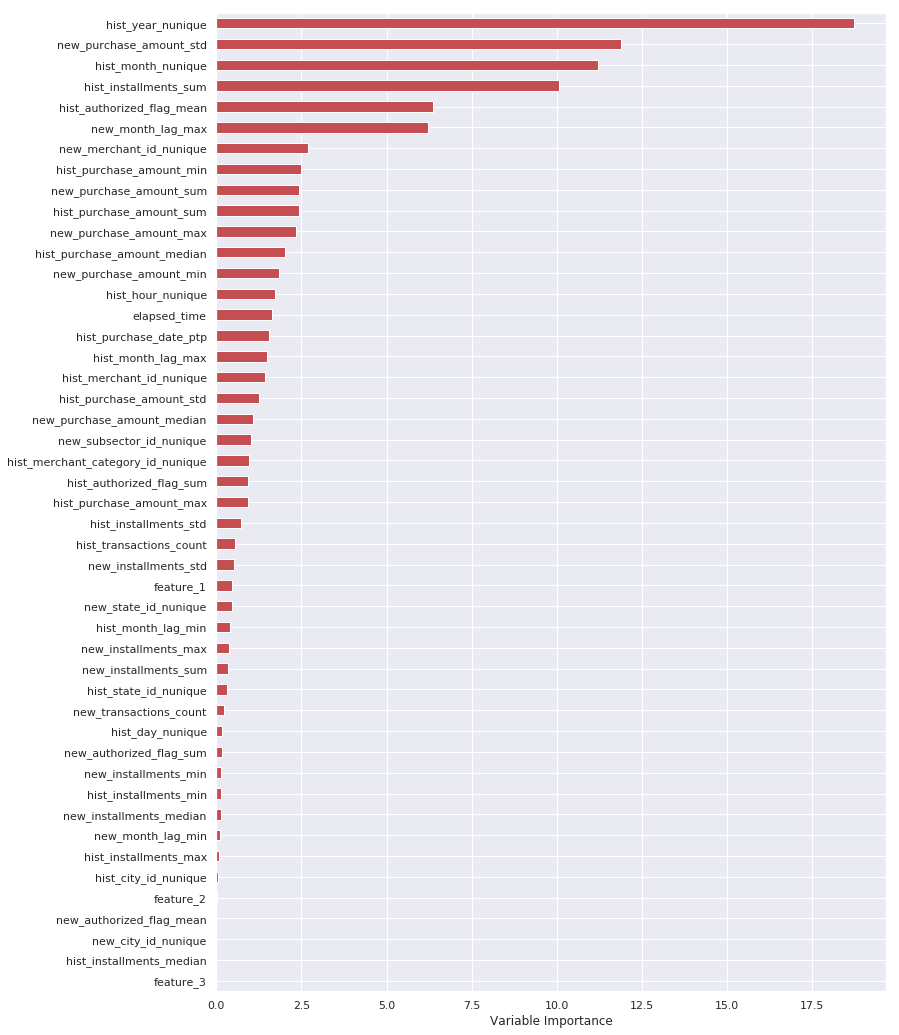

In [106]:
fig, ax = plt.subplots(figsize=(12,18))
feature_importance = rf3.feature_importances_*100
rel_imp = pd.Series(feature_importance, index=X.columns).sort_values(inplace=False)
print(rel_imp)
rel_imp.T.plot(kind='barh', color='r', ax=ax)
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

## 8. Model Submission

We used the "rf3" model to predict on X_test because we got the best RSME for this model, that is with Random Forest. Finally we could create our final_submission.csv for the Elo challenge.

In [107]:
df_test.head()

feature_1  feature_2  feature_3  elapsed_time  hist_transactions_count  \
0          2          2          1           306                       68   
1          1          2          0           396                       78   
2          4          0          1           184                       13   
3          1          0          0            62                       26   
4          4          0          1           793                      110   

   hist_authorized_flag_sum  hist_authorized_flag_mean  \
0                        44                   0.647059   
1                        77                   0.987179   
2                         9                   0.692308   
3                        26                   1.000000   
4                        87                   0.790909   

   hist_merchant_id_nunique  hist_city_id_nunique  hist_state_id_nunique  \
0                        24                     7                      3   
1                        27                     4                      3   
2                         9                     4                      4   
3                        23                     1                      1   
4                        47                     5                      4   

           ...           new_purchase_amount_std  new_installments_sum  \
0          ...                          0.182861                   5.0   
1          ...                          0.071167                  11.0   
2          ...                          1.152344                  11.0   
3          ...                          0.073181                  29.0   
4          ...                          6.027344                   5.0   

   new_installments_median  new_installments_max  new_installments_min  \
0                      1.0                   3.0                   1.0   
1                      1.0                   3.0                   1.0   
2                      5.5                  10.0                   1.0   
3                      2.0                  12.0                   1.0   
4                      1.0                   2.0                  -1.0   

   new_installments_std  new_month_lag_min  new_month_lag_max  \
0              1.154701                2.0                2.0   
1              0.666667                1.0                2.0   
2              6.363961                1.0                1.0   
3              3.348300                1.0                2.0   
4              0.983192                1.0                2.0   

   new_subsector_id_nunique  new_state_id_nunique  
0                       3.0                   1.0  
1                       6.0                   2.0  
2                       2.0                   2.0  
3                       8.0                   3.0  
4                       4.0                   2.0  

[5 rows x 47 columns]

In [108]:
X_test = df_test
X_test.head()

feature_1  feature_2  feature_3  elapsed_time  hist_transactions_count  \
0          2          2          1           306                       68   
1          1          2          0           396                       78   
2          4          0          1           184                       13   
3          1          0          0            62                       26   
4          4          0          1           793                      110   

   hist_authorized_flag_sum  hist_authorized_flag_mean  \
0                        44                   0.647059   
1                        77                   0.987179   
2                         9                   0.692308   
3                        26                   1.000000   
4                        87                   0.790909   

   hist_merchant_id_nunique  hist_city_id_nunique  hist_state_id_nunique  \
0                        24                     7                      3   
1                        27                     4                      3   
2                         9                     4                      4   
3                        23                     1                      1   
4                        47                     5                      4   

           ...           new_purchase_amount_std  new_installments_sum  \
0          ...                          0.182861                   5.0   
1          ...                          0.071167                  11.0   
2          ...                          1.152344                  11.0   
3          ...                          0.073181                  29.0   
4          ...                          6.027344                   5.0   

   new_installments_median  new_installments_max  new_installments_min  \
0                      1.0                   3.0                   1.0   
1                      1.0                   3.0                   1.0   
2                      5.5                  10.0                   1.0   
3                      2.0                  12.0                   1.0   
4                      1.0                   2.0                  -1.0   

   new_installments_std  new_month_lag_min  new_month_lag_max  \
0              1.154701                2.0                2.0   
1              0.666667                1.0                2.0   
2              6.363961                1.0                1.0   
3              3.348300                1.0                2.0   
4              0.983192                1.0                2.0   

   new_subsector_id_nunique  new_state_id_nunique  
0                       3.0                   1.0  
1                       6.0                   2.0  
2                       2.0                   2.0  
3                       8.0                   3.0  
4                       4.0                   2.0  

[5 rows x 47 columns]

In [109]:
#Create final submission
y_test = rf3.predict(X_test)
dt = pd.DataFrame({'card_id':df_card['card_id'].values})
dt['target'] = y_test
dt.to_csv('final_submission.csv', index=False)

## 9. Conclusion

The Kernel has provided one possible approach to solve the Elo Challenge. We have seen that an in-depth EDA was particulary necessary since we had different datasets that had to be joined and contained different features. Therefore the most time-consuming step was most likely EDA and Data Preprocessing in order to discover how we could actually create new features. This has not been learned before and was new to the team. Once the features have been created and the data was cleaned, we could relatively quickly apply different models. The result has shown that Random Forest turned out to be the model with the lowest RMSE. Hence, this model has been used for the final submission.